<a href="https://colab.research.google.com/github/j-ranasinghe/nlp_cw/blob/main/Solution_GroupH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers imbalanced-learn scikit-learn

In [2]:
# Standard libraries
import json
import re
import random
import string
from collections import Counter

# Data handling and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK - Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

# Spacy - NLP
import spacy

#Scipy
from scipy.sparse import load_npz

# Gensim - Word Embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


# Hugging Face Transformers
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, AutoTokenizer, pipeline

# Google Colab (for Google Drive integration)
from google.colab import drive

# Scikit-Learn - Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import LinearSVC

# Imbalanced-learn - Oversampling
from imblearn.over_sampling import SMOTE

# TensorFlow Keras - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Embedding, Bidirectional
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

# PyTorch - Deep Learning (for Hugging Face Transformers)
import torch


In [3]:
# Downloading the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Ensure you are using a GPU for BERT model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Mounts Google Drive to the '/content/drive' directory in the current runtime
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the path to the JSON file located in Google Drive
file_path = '/content/drive/MyDrive/NLP CW/full-combined-dataset.json'

# Opening the JSON file in read mode with UTF-8 encoding
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)


# **Task 1**

## **Raw data**

In [ ]:
# Displaying the first item in the raw dataset
print('Raw dataset before cleaning :\n')
data[:1]

Raw dataset before cleaning :



[{'id': '974611685',
  'url': 'https://www.tripadvisor.com/ShowUserReviews-g616035-d4465330-r974611685-Ella_Jungle_Resort-Ella_Uva_Province.html',
  'title': 'Terrible experience. Waste of time, money and nerves. Stay away.',
  'lang': 'en',
  'locationId': '4465330',
  'publishedDate': '2024-10-19',
  'publishedPlatform': 'OTHER',
  'rating': 1,
  'helpfulVotes': 1,
  'text': 'Well, no.   Big no. \nFirst of all, before booking, please go through all these comments. Look at the pictures. Not posted by the property but from guest. The place have a great potential but as of today it is just a scam. Place is undeveloped, rooms are nasty. Food terrible. All three above aspects can be fixed easily and reading that this "in a jungle" makes no sense. We travel to Sri Lanka often, staying in boutique hotels but also in a real jungle. All places can be clean and nice disputing the fact of not easy environment around. Same w/ food. Staying "in a jungle" explain nasty food served? Having so many 

## **Data Cleaning**

Extract only the specified columns




In [ ]:
# Initializing an empty list
filtered_data = []

# Iterating over each entry in the original 'data' list
for entry in data:
    # Creating a dictionary with selected fields from each entry
    filtered_entry = {
        "title": entry.get("title"),
        "lang": entry.get("lang"),
        "Date": entry.get("travelDate"),
        "rating": entry.get("rating"),
        "helpfulVotes": entry.get("helpfulVotes"),
        "text": entry.get("text"),
        "PlaceName": entry.get("placeInfo", {}).get("name"),
        "PlaceRating": entry.get("placeInfo", {}).get("rating")
    }
    # Appending the filtered entry dictionary to the 'filtered_data' list
    filtered_data.append(filtered_entry)


In [ ]:
# Displaying the first item in the 'filtered_data' list
filtered_data[:1]

[{'title': 'Terrible experience. Waste of time, money and nerves. Stay away.',
  'lang': 'en',
  'Date': '2024-08',
  'rating': 1,
  'helpfulVotes': 1,
  'text': 'Well, no.   Big no. \nFirst of all, before booking, please go through all these comments. Look at the pictures. Not posted by the property but from guest. The place have a great potential but as of today it is just a scam. Place is undeveloped, rooms are nasty. Food terrible. All three above aspects can be fixed easily and reading that this "in a jungle" makes no sense. We travel to Sri Lanka often, staying in boutique hotels but also in a real jungle. All places can be clean and nice disputing the fact of not easy environment around. Same w/ food. Staying "in a jungle" explain nasty food served? Having so many option for low-key or upscale Sri Lanka\' culinary possibilities? \n\nSo we did claim many times issues on site. Zero interest. Management\'s reaction: it is what it is, deal with it. \nImmediate decision to leave. Aft

In [ ]:
# Priniting the length of the filtered data
print(len(filtered_data))

10127


Load the data into a DataFrame

In [ ]:
# Creating a DataFrame from the 'filtered_data' list
df = pd.DataFrame(filtered_data)

In [ ]:
# Printing the head of the dataframe
df.head(1)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating
0,"Terrible experience. Waste of time, money and ...",en,2024-08,1,1,"Well, no. Big no. \nFirst of all, before boo...",Ella Jungle Resort,4.0


In [ ]:
# Creating a dictionary to store basic information
description = {
    'row_count': df.shape[0],
    'column_count': df.shape[1],
    'unique_place_names': df['PlaceName'].nunique(),
}

# Adding columns for the review length in words and characters
df['review_length_words'] = df['text'].apply(lambda x: len(x.split()))
df['review_length_chars'] = df['text'].apply(len)

# Calculating descriptive statistics for 'rating', 'helpfulVotes', and 'PlaceRating' columns
descriptive_stats = df[['rating', 'helpfulVotes', 'PlaceRating']].describe()
# Calculating minimum, maximum, and mean values for review length in words
review_length_stats = df['review_length_words'].agg(['min', 'max', 'mean'])


# Calculating the distribution of languages
lang_distribution = df['lang'].value_counts()

In [ ]:
# Printing each section with spacing for readability
print("Description of the Raw Dataset\n")
print( description, "\n")
print("Descriptive Statistics:\n", descriptive_stats, "\n")
print("Review Length Analysis:\n", review_length_stats, "\n")
print("Language Distribution:\n", lang_distribution.to_dict(), "\n")


Description of the Raw Dataset

{'row_count': 10127, 'column_count': 8, 'unique_place_names': 205} 

Descriptive Statistics:
              rating  helpfulVotes   PlaceRating
count  10127.000000  10127.000000  10127.000000
mean       4.648267      0.202232      4.537030
std        0.840836      1.006587      0.311669
min        1.000000     -1.000000      4.000000
25%        5.000000      0.000000      4.500000
50%        5.000000      0.000000      4.500000
75%        5.000000      0.000000      4.500000
max        5.000000     60.000000      5.000000 

Review Length Analysis:
 min        1.000000
max     1191.000000
mean      89.412067
Name: review_length_words, dtype: float64 

Language Distribution:
 {'en': 8966, 'de': 255, 'fr': 220, 'ru': 215, 'nl': 126, 'es': 113, 'it': 72, 'ja': 35, 'zhCN': 32, 'sv': 20, 'da': 20, 'no': 10, 'pl': 10, 'ar': 8, 'iw': 6, 'zhTW': 5, 'ko': 4, 'pt': 3, 'cs': 3, 'fi': 2, 'tr': 2} 



In [ ]:
# Printing duplicates if any
duplicates = df[df.duplicated(subset=['title', 'text'], keep=False)]

if not duplicates.empty:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")

No duplicates found.


In [ ]:
def clean_text(text):
    # Removing digits
    text = re.sub(r'\d+', '', text)
    # Removing special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Reducing repeated characters (like "loooove" to "loove")
    text = re.sub(r'(.)\1{2,}', r"\1\1", text)
    # Converting to lowercase
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Removing trailing and extra whitespaces
    text = ' '.join(text.split())
    return text

In [ ]:
# Cleaning the dataset
df['text'] = df['text'].apply(clean_text)

In [ ]:
# Droping rows where 'lang' is not 'en'
df = df[df['lang'] == "en"].reset_index(drop=True)

In [ ]:
# Removing the columns
columns_to_drop = ['review_length_words','review_length_chars']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Calculating review length in words
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

Box Plot of Review Lengths

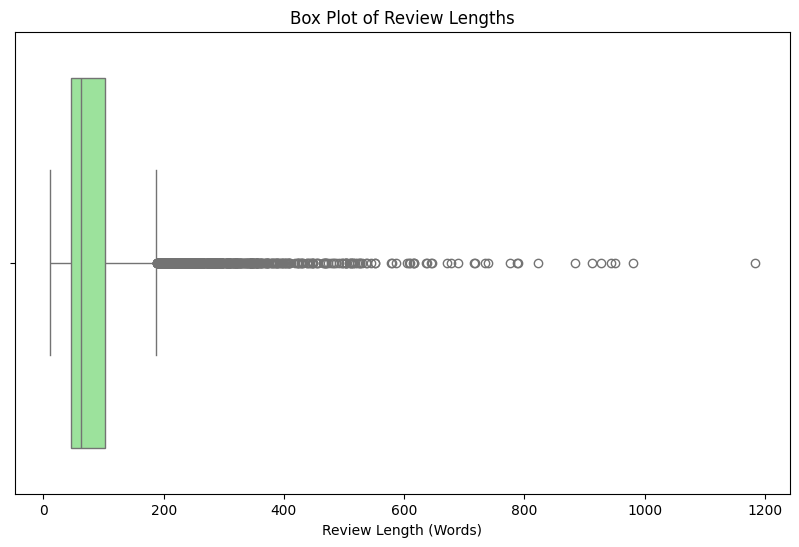

In [ ]:
# Setting up the figure with a specified width and height
plt.figure(figsize=(10, 6))

# Create a box plot for the 'review_length' column
sns.boxplot(x=df['review_length'], color='lightgreen')

# Setting the title of the plot
plt.title('Box Plot of Review Lengths')

# Labelling the x-axis
plt.xlabel('Review Length (Words)')

# Displaying the plot
plt.show()

In [ ]:
# Calculating the mean and median for the review length
mean_length = df['review_length'].mean()
median_length = df['review_length'].median()

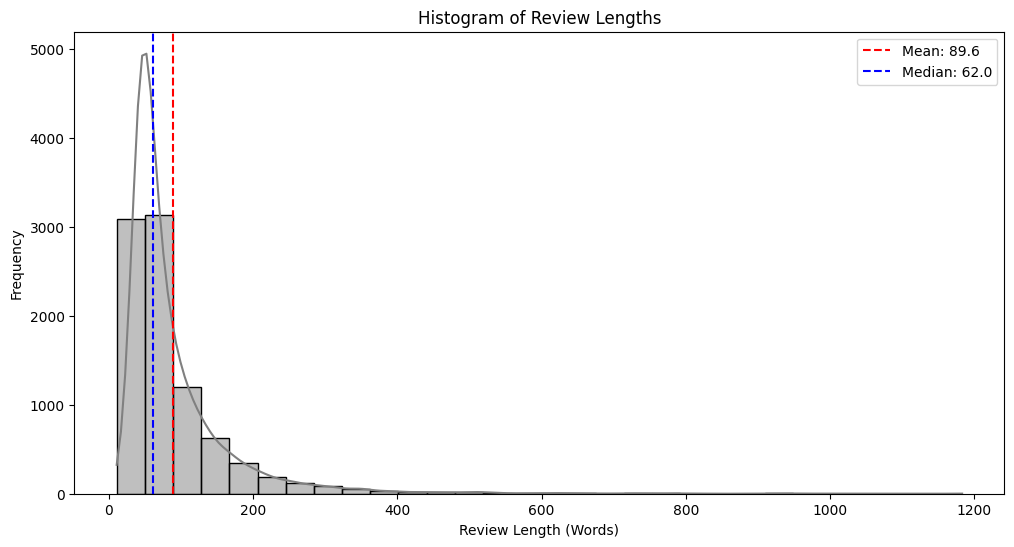

In [ ]:
# Plotting the histogram for review length
plt.figure(figsize=(12, 6))
sns.histplot(df['review_length'], bins= 30, kde=True, color="grey")
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='--', linewidth=1.5, label=f'Median: {median_length:.1f}')

plt.title("Histogram of Review Lengths")
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [ ]:
# Calculating the 5th and 95th percentiles of review lengths
lower_threshold = df['review_length'].quantile(0.02)
upper_threshold = df['review_length'].quantile(0.98)

In [ ]:
# Threshold values for review lengths to drop
print(f"5th Percentile Threshold (Minimum Length): {lower_threshold}")
print(f"95th Percentile Threshold (Maximum Length): {upper_threshold}\n")

5th Percentile Threshold (Minimum Length): 31.0
95th Percentile Threshold (Maximum Length): 323.0



In [ ]:
# Filtering out the reviews below the 5th percentile and above the 95th percentile
lower_bound = df[df['review_length'] < lower_threshold]
upper_bound = df[df['review_length'] > upper_threshold]

In [ ]:
# The number of reviews below the 5th and above the 95th percentiles
print(f"Number of reviews below the 2nd percentile: {len(lower_bound)}")
print(f"Number of reviews above the 98th percentile: {len(upper_bound)}")

Number of reviews below the 2nd percentile: 157
Number of reviews above the 98th percentile: 179


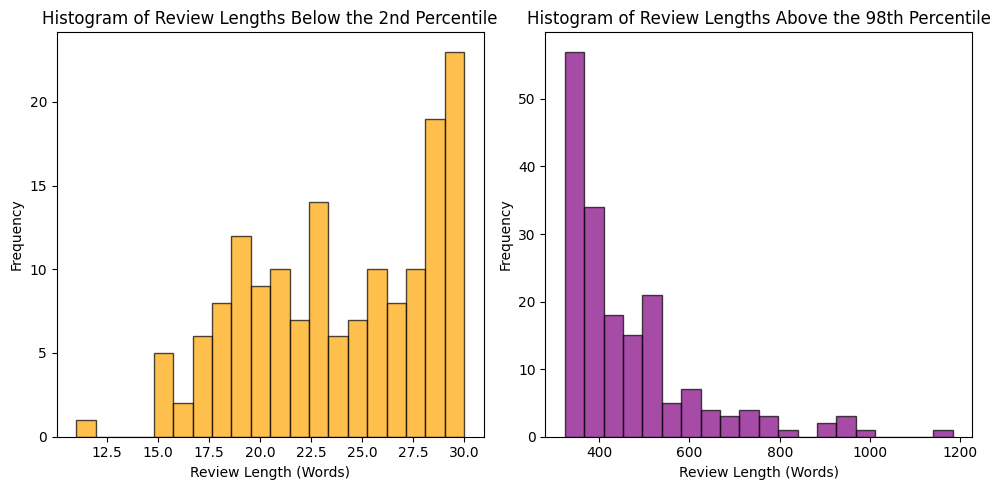

In [ ]:
# Histogram of Review Lengths Below the 2nd Percentile AND Review Lengths Above the 98th Percentile
plt.figure(figsize=(10, 5))

# Plotting histogram for reviews below the 5th percentile
plt.subplot(1, 2, 1)
plt.hist(lower_bound['review_length'], bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths Below the 2nd Percentile')

# Plotting histogram for reviews above the 95th percentile
plt.subplot(1, 2, 2)
plt.hist(upper_bound['review_length'], bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths Above the 98th Percentile')
plt.tight_layout()
plt.show()

In [ ]:
# Dropping the reviews less than teh 2nd percentile and higher than the 98th percentile
df_cleaned = df[(df['review_length'] >= lower_threshold) & (df['review_length'] <= upper_threshold)].copy()

Histogram after filtering reviews based on length

# EDA of cleaned dataset

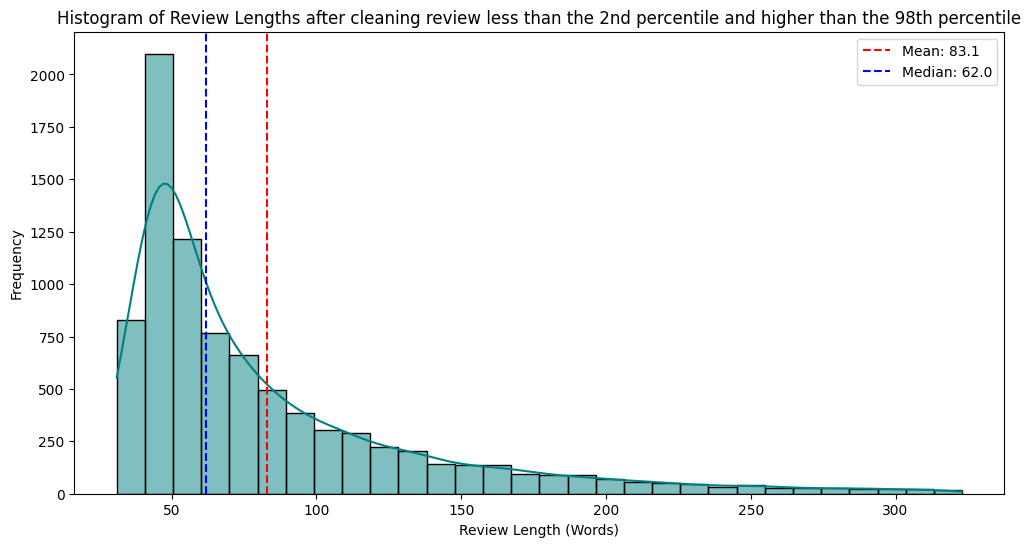

In [ ]:
# Calculating the mean and median for the review length after cleaning review less than teh 2nd percentile and higher than the 98th percentile
mean_length = df_cleaned['review_length'].mean()
median_length = df_cleaned['review_length'].median()

# Plotting the histogram for review length
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['review_length'], bins= 30, kde=True, color="teal")
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='--', linewidth=1.5, label=f'Median: {median_length:.1f}')

plt.title("Histogram of Review Lengths after cleaning review less than the 2nd percentile and higher than the 98th percentile")
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [ ]:
# Shape of dataset after cleaning
df_cleaned.shape

(8630, 9)

In [ ]:
# Dataset after cleaning
df_cleaned.head(3)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length
0,"Terrible experience. Waste of time, money and ...",en,2024-08,1,1,well no big no first of all before booking ple...,Ella Jungle Resort,4.0,275
1,Ella Jungle resort you should never miss!,en,2022-06,5,1,it is one of the most amazing stay we ever had...,Ella Jungle Resort,4.0,61
2,Must visit when in Ella,en,2024-10,5,0,i dont why there are negative reviews its a ju...,Ella Jungle Resort,4.0,151


In [ ]:
# Summary statistics for numerical columns after cleaning
print(df_cleaned[['rating', 'helpfulVotes', 'PlaceRating']].describe())


            rating  helpfulVotes  PlaceRating
count  8630.000000   8630.000000  8630.000000
mean      4.682155      0.211935     4.546929
std       0.796850      1.073246     0.311538
min       1.000000     -1.000000     4.000000
25%       5.000000      0.000000     4.500000
50%       5.000000      0.000000     4.500000
75%       5.000000      0.000000     4.500000
max       5.000000     60.000000     5.000000


In [ ]:
# Number of hotels in the dataset
num_hotels = df_cleaned['PlaceName'].nunique()
print(f"Number of Hotels: {num_hotels}")


Number of Hotels: 205


In [ ]:
# Getting the number of reviews
reviews_per_hotel = df_cleaned.groupby('PlaceName').size()
print(reviews_per_hotel.describe())


count    205.000000
mean      42.097561
std        7.964397
min        9.000000
25%       38.000000
50%       45.000000
75%       48.000000
max       50.000000
dtype: float64


In [ ]:
# Split all words in the 'text' column
all_words = ' '.join(df_cleaned['text']).split()
word_counts = Counter(all_words)

# Total words and unique words
total_words = len(all_words)
unique_words = len(word_counts)

print(f"Total Words: {total_words}")
print(f"Unique Words: {unique_words}")


Total Words: 716893
Unique Words: 19998


In [ ]:
# Printing the most common 10 words and the count of each word
print(f'Most common words\n: {word_counts.most_common(10)}')

Most common words
: [('the', 46089), ('and', 33340), ('a', 18806), ('to', 17682), ('was', 15067), ('we', 11870), ('of', 10204), ('is', 9938), ('in', 9282), ('for', 8737)]


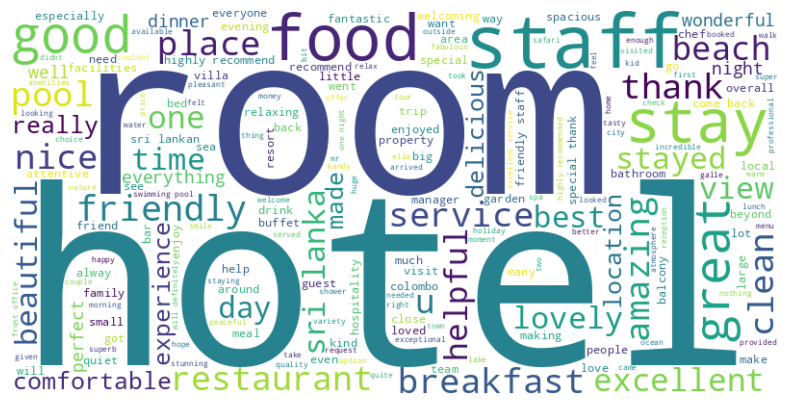

In [ ]:
# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

Histogram of Rating Distribution

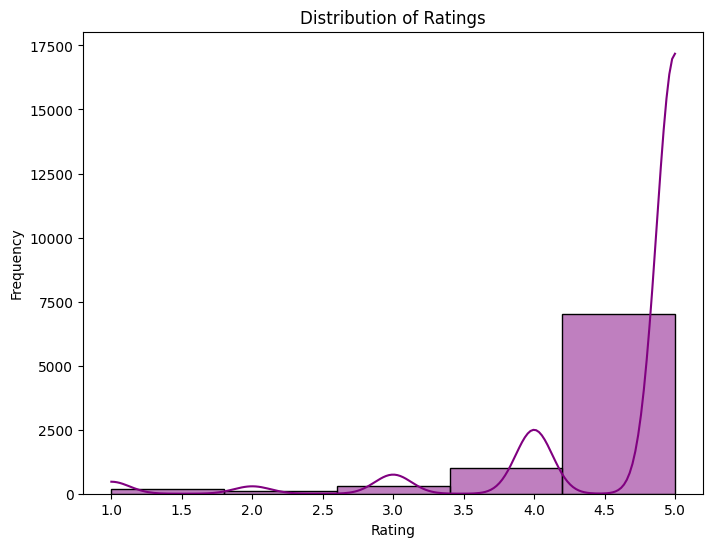

In [ ]:
# Plotting the histogram of rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['rating'], bins=5, kde=True, color='purple')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

Rating distribution as pie chart

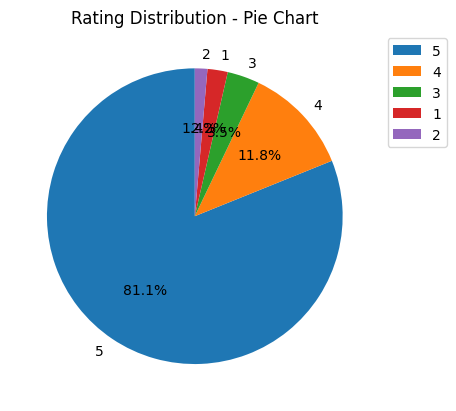

In [ ]:
# Plotting the rating distribution as a pie chart
ratings_counts = df_cleaned['rating'].value_counts()
plt.pie(ratings_counts, labels=ratings_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Rating Distribution - Pie Chart')
plt.legend( loc = 'upper right', bbox_to_anchor=(1.2, 1))
plt.show()


Seasonal Trends: Average Rating by Month and Year

In [ ]:
# Converting 'Date' to datetime format and extract the month and year into new columns
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned['month'] = df_cleaned['Date'].dt.month
df_cleaned['year'] = df_cleaned['Date'].dt.year

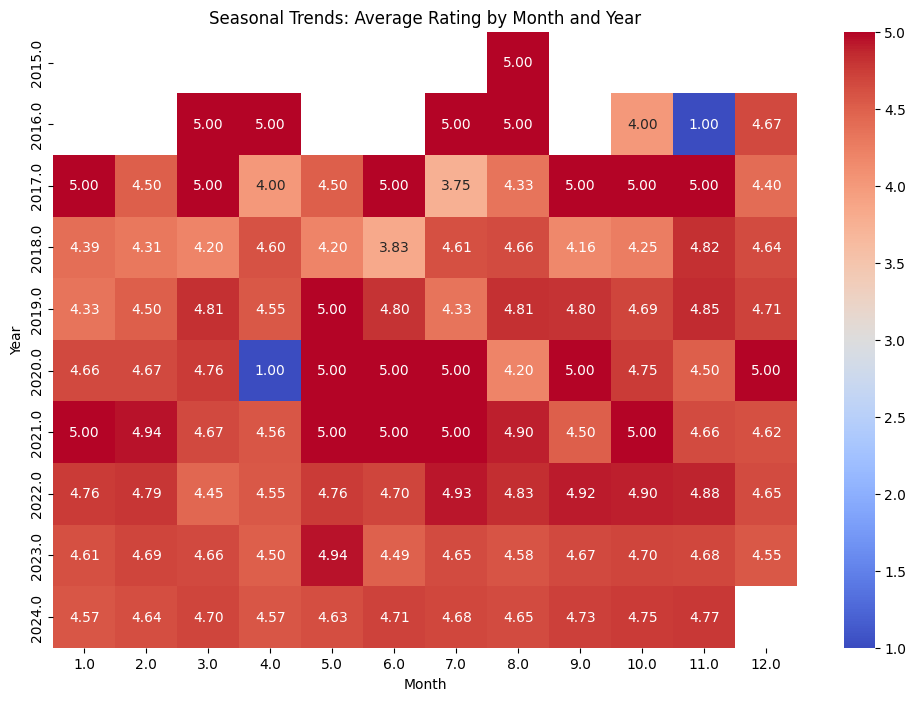

In [ ]:
# Grouping by year and month, and get the average rating
monthly_yearly_ratings = df_cleaned.groupby(['year', 'month'])['rating'].mean().unstack()

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_yearly_ratings, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Seasonal Trends: Average Rating by Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


In [ ]:
# Dropping the columns
columns_to_drop = ['year','month']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

Effectiveness of the different (subword) tokenization schemes

In [ ]:
# Sample 2 reviews from 'df_cleaned' for testing tokenization methods with NLTK, SpaCy, GPT-2, and BERT;
# each function tokenizes text, removing stopwords where applicable for NLTK and SpaCy.
sample_df = df_cleaned.sample(n=2, random_state=42)  # 2 reviews from the  df

# Tokenization and stopword removal functions
def nltk_tokenization_stopwords(text):
    stop_words_nltk = set(stopwords.words('english'))
    tokenized_corpus_nltk = word_tokenize(text)
    tokenized_corpus_without_stopwords_nltk = [word for word in tokenized_corpus_nltk if word.lower() not in stop_words_nltk]
    return tokenized_corpus_without_stopwords_nltk

def spacy_tokenization_stopwords(text):
    spacy_model = spacy.load('en_core_web_sm')
    stopwords_spacy = spacy_model.Defaults.stop_words
    tokenized_corpus_spacy = [token.text for token in spacy_model(text)]
    tokenized_corpus_without_stopwords_spacy = [word for word in tokenized_corpus_spacy if word.lower() not in stopwords_spacy]
    return tokenized_corpus_without_stopwords_spacy

def gpt2_tokenization(text):
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2_tokens = gpt2_tokenizer.tokenize(text)
    return gpt2_tokens

def bert_tokenization(text):
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_tokens = bert_tokenizer.tokenize(text)
    return bert_tokens

In [ ]:
# Applying tokenization methods to the sample review dataset
sample_df['nltk_tokens'] = sample_df['text'].apply(nltk_tokenization_stopwords)
sample_df['spacy_tokens'] = sample_df['text'].apply(spacy_tokenization_stopwords)
sample_df['gpt2_tokens'] = sample_df['text'].apply(gpt2_tokenization)
sample_df['bert_tokens'] = sample_df['text'].apply(bert_tokenization)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Printing the tokenization comparison for the sampled dataset
print("Tokenization Comparison:")
for index, row in sample_df.iterrows():
    print("\nOriginal Review Text:")
    print(row['text'])
    print("\nNLTK Tokens (with stopwords removed):")
    print(row['nltk_tokens'])
    print("\nspaCy Tokens (with stopwords removed):")
    print(row['spacy_tokens'])
    print("\nGPT-2 Tokens (Byte-Pair Encoding):")
    print(row['gpt2_tokens'])
    print("\nBERT Tokens (WordPiece):")
    print(row['bert_tokens'])

Tokenization Comparison:

Original Review Text:
this place is awesome been here more than once and definitely will come back again staff ms kavishka was really helpful and kind too the rooms and common areas are really clean and tidy they have very kind and helpful staff members we all had a great stay here

NLTK Tokens (with stopwords removed):
['place', 'awesome', 'definitely', 'come', 'back', 'staff', 'ms', 'kavishka', 'really', 'helpful', 'kind', 'rooms', 'common', 'areas', 'really', 'clean', 'tidy', 'kind', 'helpful', 'staff', 'members', 'great', 'stay']

spaCy Tokens (with stopwords removed):
['place', 'awesome', 'definitely', 'come', 'staff', 'ms', 'kavishka', 'helpful', 'kind', 'rooms', 'common', 'areas', 'clean', 'tidy', 'kind', 'helpful', 'staff', 'members', 'great', 'stay']

GPT-2 Tokens (Byte-Pair Encoding):
['this', 'Ġplace', 'Ġis', 'Ġawesome', 'Ġbeen', 'Ġhere', 'Ġmore', 'Ġthan', 'Ġonce', 'Ġand', 'Ġdefinitely', 'Ġwill', 'Ġcome', 'Ġback', 'Ġagain', 'Ġstaff', 'Ġms', 'Ġk', 'a

In [ ]:
# Writing cleaned dataset to csv file
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

Explain the challenges encountered and the observations based on the output above



---



### Answer to Task 2

Describe the classification dataset, its dimensions, preprocessing steps, numbers of classes taken for classification, the which feature extraction techniques were performed.

In [ ]:
# Loading the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/NLP CW/cleaned_dataset.csv')

In [ ]:
# Shaping of the cleaned dataset
df.shape

(8630, 9)

In [ ]:
# Printing the cleaned dataset
df.head(2)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length
0,"Terrible experience. Waste of time, money and ...",en,2024-08-01,1,1,well no big no first of all before booking ple...,Ella Jungle Resort,4.0,275
1,Ella Jungle resort you should never miss!,en,2022-06-01,5,1,it is one of the most amazing stay we ever had...,Ella Jungle Resort,4.0,61


## Preprocessing steps

1. Tokenization, Stopword Removal, and Lemmatization with spaCy (for Lexicon and ML Classifiers)
2. Subword Tokenization with GPT-2 for DL Classifier





Tokenization, Stopword Removal, and Lemmatization with spaCy

In [ ]:
# Loading the SpaCy language model
nlp = spacy.load("en_core_web_sm")

def preprocess_spacy(text):
    doc = nlp(text)
    # Filter out stop words and non-alphabetic tokens --> lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

#Applying to text column and save the tokens to new column
df['lexicon_ml_tokens'] = df['text'].apply(preprocess_spacy)

Subword Tokenization with GPT-2


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize each review into subwords
def gpt2_tokenize(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    return tokens

# Applying to text column and save the tokens to new column
df['dl_tokens'] = df['text'].apply(gpt2_tokenize)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Ground truth labelling process
1. Classifier 1 : Lexicon Based (VADER)
2. Classifier 2 : Lexicon Based (TextBlob)
3. Classifier 3 : DL-Based (distilbert-base-uncased-finetuned-sst-2-english)



*   Get majority Vote from VADER, DistilBERT, and Bing Liu Lexicon and get the final sentiment(Ground Truth)




Classifier 1: Lexicon-Based  -- VADER


In [ ]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get binary sentiment
def vader_sentiment_binary(text):
    scores = sia.polarity_scores(text)
    # Classify only as "positive" or "negative"
    return 'positive' if scores['compound'] >= 0 else 'negative'

# Function to get sentiment
def vader_sentiment_multi(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis to text column
df['vader_sentiment_multi'] = df['text'].apply(vader_sentiment_multi)

# Apply the binary VADER sentiment analysis to text column
df['vader_sentiment'] = df['text'].apply(vader_sentiment_binary)

# Display the results
print(df[['text', 'vader_sentiment']].head(3))
print(df[['text', 'vader_sentiment_multi']].head(3))

                                                text vader_sentiment
0  well no big no first of all before booking ple...        positive
1  it is one of the most amazing stay we ever had...        positive
2  i dont why there are negative reviews its a ju...        positive
                                                text vader_sentiment_multi
0  well no big no first of all before booking ple...              positive
1  it is one of the most amazing stay we ever had...              positive
2  i dont why there are negative reviews its a ju...              positive


Classifier 2: Lexicon-Based  -- TextBlob

In [ ]:
from textblob import TextBlob

def textblob_sentiment_binary(text):
    # Get polarity score
    polarity = TextBlob(text).sentiment.polarity
    # Return binary sentiment
    return 'positive' if polarity >= 0.2 else 'negative'

def textblob_sentiment_multi(text):
    # Get polarity score
    polarity = TextBlob(text).sentiment.polarity
    # Return sentiment based on polarity score
    if polarity >= 0.2:
        return 'positive'
    elif polarity <= -0.2:
        return 'negative'
    else:
        return 'neutral'

# Apply the TextBlob sentiment analysis to the 'text' column for binary sentiments
df['textblob_sentiment'] = df['text'].apply(textblob_sentiment_binary)

# Apply the TextBlob sentiment analysis to the 'text' column for multi sentiments
df['textblob_sentiment_multi'] = df['text'].apply(textblob_sentiment_multi)

# Display the results
print(df[['text', 'textblob_sentiment']].head(3))
print(df[['text', 'textblob_sentiment_multi']].head(3))

                                                text textblob_sentiment
0  well no big no first of all before booking ple...           negative
1  it is one of the most amazing stay we ever had...           positive
2  i dont why there are negative reviews its a ju...           positive
                                                text textblob_sentiment_multi
0  well no big no first of all before booking ple...                  neutral
1  it is one of the most amazing stay we ever had...                 positive
2  i dont why there are negative reviews its a ju...                 positive


Classifier 3: DL-Based -- DistilBERT

In [ ]:
# Load the DistilBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device =0)

def decode_and_analyze(tokens):
    # Decode the tokens back into text
    decoded_text = tokenizer.decode(tokens, skip_special_tokens=True)
    sentiment = sentiment_pipeline(decoded_text)[0]['label'].lower()
    return sentiment

# Apply the function to the 'dl_tokens' column
df['dl_sentiment'] = df['dl_tokens'].apply(decode_and_analyze)

# Display the results
print(df[['text', 'dl_sentiment']].head(3))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text dl_sentiment
0  well no big no first of all before booking ple...     negative
1  it is one of the most amazing stay we ever had...     positive
2  i dont why there are negative reviews its a ju...     positive


 Majority Vote with VADER, DistilBERT, and Textblob







In [ ]:
def final_majority_vote_binary(row):
    sentiments = [row['vader_sentiment'], row['dl_sentiment'], row['textblob_sentiment']]
    return Counter(sentiments).most_common(1)[0][0]

def final_majority_vote_multi(row):
    sentiments = [row['vader_sentiment_multi'], row['dl_sentiment'], row['textblob_sentiment_multi']]
    return Counter(sentiments).most_common(1)[0][0]

# Apply majority voting
df['final_sentiment'] = df.apply(final_majority_vote_binary, axis=1)
df['final_sentiment_multi'] = df.apply(final_majority_vote_multi, axis=1)

In [ ]:
# Drop the individual classifier sentiment columns
df.drop(columns=['vader_sentiment', 'textblob_sentiment', 'dl_sentiment', 'vader_sentiment_multi', 'dl_sentiment', 'textblob_sentiment_multi'], inplace=True)

In [ ]:
#write labeled dataset to csv file
#df.to_csv('labeled_dataset_v1.csv', index=False)

In [ ]:
df.head(3)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length,lexicon_ml_tokens,dl_tokens,final_sentiment,final_sentiment_multi
0,"Terrible experience. Waste of time, money and ...",en,2024-08-01,1,1,well no big no first of all before booking ple...,Ella Jungle Resort,4.0,275,"[big, book, comment, look, picture, post, prop...","[4053, 645, 1263, 645, 717, 286, 477, 878, 254...",negative,positive
1,Ella Jungle resort you should never miss!,en,2022-06-01,5,1,it is one of the most amazing stay we ever had...,Ella Jungle Resort,4.0,61,"[amazing, stay, sri, lanka, exciting, surround...","[270, 318, 530, 286, 262, 749, 4998, 2652, 356...",positive,positive
2,Must visit when in Ella,en,2024-10-01,5,0,i dont why there are negative reviews its a ju...,Ella Jungle Resort,4.0,151,"[not, negative, review, jungle, resort, live, ...","[72, 17666, 1521, 612, 389, 4633, 8088, 663, 2...",positive,positive


In [ ]:
# Dataset Dimensions
num_rows = df.shape[0]
num_columns = df.shape[1]
print(f"\nDataset Dimensions: {num_rows} rows and {num_columns} columns")


Dataset Dimensions: 8630 rows and 13 columns


In [ ]:
# Distribution of Sentiment Classes
class_distribution = df['final_sentiment'].value_counts()
print("\nSentiment Binary Class Distribution:")
print(class_distribution)

# Number of Classes for Classification
num_classes = class_distribution.shape[0]
print(f"\nNumber of Classes for Classification: {num_classes}")

# Distribution of Multi nSentiment Classes
class_distribution_multi = df['final_sentiment_multi'].value_counts()
print("\nSentiment Multi Class Distribution:")
print(class_distribution_multi)

# Number of Classes for multi Classification
num_classes = class_distribution_multi.shape[0]
print(f"\nNumber of Classes for Classification: {num_classes}")


Sentiment Binary Class Distribution:
final_sentiment
positive    8103
negative     527
Name: count, dtype: int64

Number of Classes for Classification: 2

Sentiment Multi Class Distribution:
final_sentiment_multi
positive    8334
negative     285
neutral       11
Name: count, dtype: int64

Number of Classes for Classification: 3


Pie chart of sentiment distribution

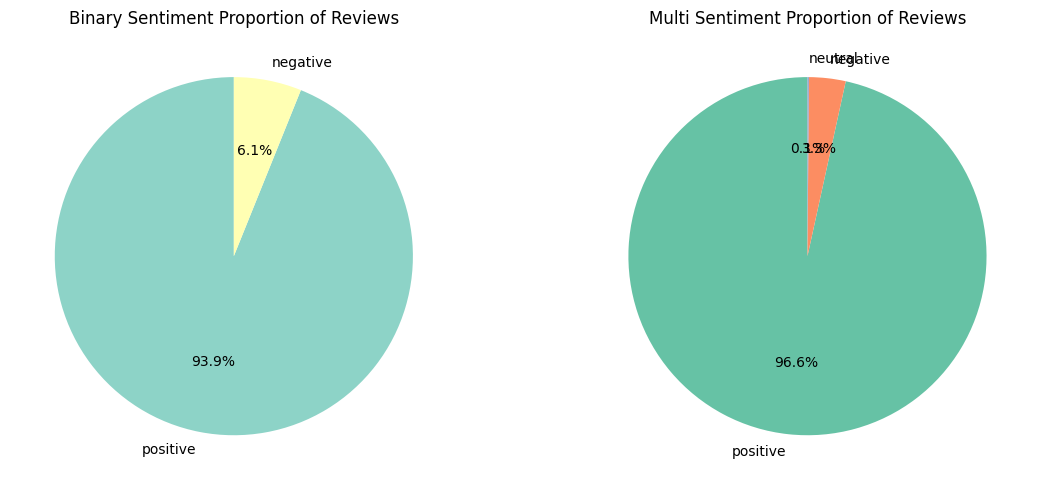

In [ ]:
sentiment_counts = df['final_sentiment'].value_counts()
sentiment_counts_multi = df['final_sentiment_multi'].value_counts()

plt.figure(figsize=(12, 5))

# Plotting histogram for binary reviews
plt.subplot(1, 2, 1)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3', len(sentiment_counts)))
plt.title('Binary Sentiment Proportion of Reviews')

# Plotting histogram for multi reviews
plt.subplot(1, 2, 2)
plt.pie(sentiment_counts_multi, labels=sentiment_counts_multi.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', len(sentiment_counts_multi)))
plt.title('Multi Sentiment Proportion of Reviews')

plt.tight_layout()
plt.show()

### Answer to Task 3

Justify the 3 non-deep learning algorithms you are using for classification.

In [ ]:
#Load the cleaned dataset
df_labeled = pd.read_csv('/content/drive/MyDrive/NLP CW/labeled_dataset_v1.csv')

## Sparse Vectorizers

### 1) Count Vectorizer

In [ ]:
# Instantiate the Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')  # Limit to 5000 features for efficiency

# Transform the text data
count_vectors = count_vectorizer.fit_transform(df_labeled['text'])

# Output the resulting matrix's shape
print("Count Vectorizer Shape:", count_vectors.shape)


Count Vectorizer Shape: (8630, 5000)


### 2) NGram TF-IDF Vectorizer

In [ ]:
# Instantiate the TF-IDF Vectorizer with n-grams
ngram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000)

# Fit and transform the text data
ngram_tfidf_vectors = ngram_tfidf_vectorizer.fit_transform(df_labeled['text'])

# Print the shape of the resulting sparse matrix
print(f"N-Gram TF-IDF Matrix Shape: {ngram_tfidf_vectors.shape}")

N-Gram TF-IDF Matrix Shape: (8630, 5000)


### 3) Hashing Vectorizer

In [ ]:
# Instantiate the Hashing Vectorizer
hashing_vectorizer = HashingVectorizer(n_features=5000)

# Transform the text data
hashing_vectors = hashing_vectorizer.transform(df_labeled['text'])

# Print the shape of the resulting sparse matrix
print(f"Hashing Vectorizer Matrix Shape: {hashing_vectors.shape}")

Hashing Vectorizer Matrix Shape: (8630, 5000)


## Dense Vectorizers

### 1) Word 2 Vec Vectorizer

In [ ]:
# Tokenize the text
df_labeled['tokenized_text'] = df_labeled['text'].apply(lambda x: word_tokenize(x.lower()))

# Instantiate and train the Word2Vec model
word2vec_model = Word2Vec(sentences=df_labeled['tokenized_text'], vector_size=300, window=5, min_count=1, workers=4)

# Define a function to create document embeddings by averaging word vectors
def average_word2vec(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

# Apply the function to create document embeddings
df_labeled['word2vec_embedding'] = df_labeled['tokenized_text'].apply(lambda x: average_word2vec(x, word2vec_model))
word2vec_vectors = np.vstack(df_labeled['word2vec_embedding'].values)

# Output the resulting matrix's shape
print("Word2Vec Embedding Shape:", word2vec_vectors.shape)


Word2Vec Embedding Shape: (8630, 300)


### 2) GloVe Vectorizer

In [ ]:
# Load GloVe model
glove_path = '/content/drive/MyDrive/NLP CW/glove.6B.300d.txt'
glove = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

# Function to compute average GloVe embeddings
def get_average_glove_embeddings(text):
    words = text.split()
    word_vectors = [glove[word] for word in words if word in glove]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)

# Apply to dataset
glove_vectors = np.array([get_average_glove_embeddings(text) for text in df_labeled['text']])

# Print the shape of the resulting dense matrix
print(f"GloVe Embeddings Matrix Shape: {glove_vectors.shape}")


GloVe Embeddings Matrix Shape: (8630, 300)


### 3) FastText Vectorizer

In [ ]:
from gensim.models import FastText

# Tokenize text for FastText model
tokenized_texts = df_labeled['text'].apply(lambda x: x.split())

# Train a FastText model
fasttext_model = FastText(sentences=tokenized_texts, vector_size=300, window=5, min_count=2, workers=4, sg=1)

# Function to calculate average FastText embeddings
def get_average_fasttext_embeddings(text):
    words = text.split()
    word_vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)

# Apply to dataset
fasttext_vectors = np.array([get_average_fasttext_embeddings(text) for text in df_labeled['text']])

# Print the shape of the resulting dense matrix
print(f"FastText Embeddings Matrix Shape: {fasttext_vectors.shape}")


FastText Embeddings Matrix Shape: (8630, 300)


In [ ]:
# Save sparse vector matrices
from scipy.sparse import save_npz
save_npz('count_vectors.npz', count_vectors)
save_npz('ngram_tfidf_vectors.npz', ngram_tfidf_vectors)
save_npz('hashing_vectors.npz', hashing_vectors)

# Save dense vector matrices
np.save('word2vec_matrix.npy', word2vec_vectors)
np.save('fasttext_matrix.npy', fasttext_vectors)
np.save('glove_matrix.npy', glove_vectors)

In [ ]:
#ADD THE REPRESENTATION

Compare and interpret the results of the different algorithms and feature extraction methods on the text classification task.

### Answer to Task 4

Describe the contextual embedding used and it's effect on the performance of the algorithms selected in Task 3.

In [ ]:
# Load sparse matrices from Google Drive
count_vectors = load_npz('/content/drive/MyDrive/NLP CW/count_vectors.npz')
ngram_tfidf_vectors = load_npz('/content/drive/MyDrive/NLP CW/ngram_tfidf_vectors.npz')
hashing_vectors = load_npz('/content/drive/MyDrive/NLP CW/hashing_vectors.npz')

# Print shapes to verify
print("Count Vectors Shape:", count_vectors.shape)
print("N-Gram TF-IDF Vectors Shape:", ngram_tfidf_vectors.shape)
print("Hashing Vectors Shape:", hashing_vectors.shape)

# Load dense matrices from Google Drive
word2vec_matrix = np.load('/content/drive/MyDrive/NLP CW/word2vec_matrix.npy')
glove_matrix = np.load('/content/drive/MyDrive/NLP CW/glove_matrix.npy')
fasttext_matrix = np.load('/content/drive/MyDrive/NLP CW/fasttext_matrix.npy')

# Print shapes to verify
print("Word2Vec Matrix Shape:", word2vec_matrix.shape)
print("GloVe Matrix Shape:", glove_matrix.shape)
print("FastText Matrix Shape:", fasttext_matrix.shape)

Count Vectors Shape: (8630, 5000)
N-Gram TF-IDF Vectors Shape: (8630, 5000)
Hashing Vectors Shape: (8630, 5000)
Word2Vec Matrix Shape: (8630, 300)
GloVe Matrix Shape: (8630, 300)
FastText Matrix Shape: (8630, 300)


In [ ]:
# Initialize SMOTE with a reduced number of neighbors
smote = SMOTE(random_state=42, k_neighbors=2)  # Adjusted k_neighbors

# Split and resample for Count Vectors
print("\nProcessing Count Vectors...")
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(
    count_vectors, df_labeled["final_sentiment"], test_size=0.2, random_state=42
)
print("Class distribution before resampling (Count Vectors):\n", y_train_count.value_counts())
X_train_count_balanced, y_train_count_balanced = smote.fit_resample(X_train_count, y_train_count)
print("Class distribution after resampling (Count Vectors):\n", y_train_count_balanced.value_counts())

# Split and resample for N-Gram TF-IDF Vectors
print("\nProcessing N-Gram TF-IDF Vectors...")
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    ngram_tfidf_vectors, df_labeled["final_sentiment"], test_size=0.2, random_state=42
)
print("Class distribution before resampling (N-Gram TF-IDF):\n", y_train_tfidf.value_counts())
X_train_tfidf_balanced, y_train_tfidf_balanced = smote.fit_resample(X_train_tfidf, y_train_tfidf)
print("Class distribution after resampling (N-Gram TF-IDF):\n", y_train_tfidf_balanced.value_counts())

# Split and resample for Hashing Vectors
print("\nProcessing Hashing Vectors...")
X_train_hashing, X_test_hashing, y_train_hashing, y_test_hashing = train_test_split(
    hashing_vectors, df_labeled["final_sentiment"], test_size=0.2, random_state=42
)
print("Class distribution before resampling (Hashing Vectors):\n", y_train_hashing.value_counts())
X_train_hashing_balanced, y_train_hashing_balanced = smote.fit_resample(X_train_hashing, y_train_hashing)
print("Class distribution after resampling (Hashing Vectors):\n", y_train_hashing_balanced.value_counts())

# Split and resample for Word2Vec Matrix
print("\nProcessing Word2Vec Matrix...")
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    word2vec_matrix, df_labeled["final_sentiment"], test_size=0.2, random_state=42
)
print("Class distribution before resampling (Word2Vec):\n", y_train_word2vec.value_counts())
X_train_word2vec_balanced, y_train_word2vec_balanced = smote.fit_resample(X_train_word2vec, y_train_word2vec)
print("Class distribution after resampling (Word2Vec):\n", y_train_word2vec_balanced.value_counts())

# Split and resample for GloVe Matrix
print("\nProcessing GloVe Matrix...")
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    glove_matrix, df_labeled["final_sentiment"], test_size=0.2, random_state=42
)
print("Class distribution before resampling (GloVe):\n", y_train_glove.value_counts())
X_train_glove_balanced, y_train_glove_balanced = smote.fit_resample(X_train_glove, y_train_glove)
print("Class distribution after resampling (GloVe):\n", y_train_glove_balanced.value_counts())

# Split and resample for FastText Matrix
print("\nProcessing FastText Matrix...")
X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext = train_test_split(
    fasttext_matrix, df_labeled["final_sentiment"], test_size=0.2, random_state=42
)
print("Class distribution before resampling (FastText):\n", y_train_fasttext.value_counts())
X_train_fasttext_balanced, y_train_fasttext_balanced = smote.fit_resample(X_train_fasttext, y_train_fasttext)
print("Class distribution after resampling (FastText):\n", y_train_fasttext_balanced.value_counts())

# Output shapes for verification
print("\nShapes After Resampling:")
print("Count Vectors: Training Shape (Balanced):", X_train_count_balanced.shape)
print("N-Gram TF-IDF Vectors: Training Shape (Balanced):", X_train_tfidf_balanced.shape)
print("Hashing Vectors: Training Shape (Balanced):", X_train_hashing_balanced.shape)
print("Word2Vec Matrix: Training Shape (Balanced):", X_train_word2vec_balanced.shape)
print("GloVe Matrix: Training Shape (Balanced):", X_train_glove_balanced.shape)
print("FastText Matrix: Training Shape (Balanced):", X_train_fasttext_balanced.shape)



Processing Count Vectors...
Class distribution before resampling (Count Vectors):
 final_sentiment
positive    6496
negative     408
Name: count, dtype: int64
Class distribution after resampling (Count Vectors):
 final_sentiment
positive    6496
negative    6496
Name: count, dtype: int64

Processing N-Gram TF-IDF Vectors...
Class distribution before resampling (N-Gram TF-IDF):
 final_sentiment
positive    6496
negative     408
Name: count, dtype: int64
Class distribution after resampling (N-Gram TF-IDF):
 final_sentiment
positive    6496
negative    6496
Name: count, dtype: int64

Processing Hashing Vectors...
Class distribution before resampling (Hashing Vectors):
 final_sentiment
positive    6496
negative     408
Name: count, dtype: int64
Class distribution after resampling (Hashing Vectors):
 final_sentiment
positive    6496
negative    6496
Name: count, dtype: int64

Processing Word2Vec Matrix...
Class distribution before resampling (Word2Vec):
 final_sentiment
positive    6496
ne

In [ ]:
# Dictionary to store evaluation metrics for visualization
evaluation_metrics = {
    "Vectorizer": [],
    "Model": [],
    "Accuracy": [],
    "Confusion_Matrix": [],
    "Classification_Report": []
}

1) Logistic Regression

In [ ]:
def evaluate_logistic_regression(X_train, X_test, y_train, y_test, feature_name):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)  # Use dict format for visualization

    # Print metrics
    print(f"\nResults for Logistic Regression with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics
    evaluation_metrics["Vectorizer"].append(feature_name)
    evaluation_metrics["Model"].append("Logistic Regression")
    evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    evaluation_metrics["Confusion_Matrix"].append(cm)
    evaluation_metrics["Classification_Report"].append(cr)


2) SVM

In [ ]:
def evaluate_svm(X_train, X_test, y_train, y_test, feature_name):
    model = LinearSVC(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Print metrics
    print(f"\nResults for SVM with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics
    evaluation_metrics["Vectorizer"].append(feature_name)
    evaluation_metrics["Model"].append("SVM")
    evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    evaluation_metrics["Confusion_Matrix"].append(cm)
    evaluation_metrics["Classification_Report"].append(cr)


3) Random Forest

In [ ]:
def evaluate_random_forest(X_train, X_test, y_train, y_test, feature_name):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Print metrics
    print(f"\nResults for Random Forest with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics
    evaluation_metrics["Vectorizer"].append(feature_name)
    evaluation_metrics["Model"].append("Random Forest")
    evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    evaluation_metrics["Confusion_Matrix"].append(cm)
    evaluation_metrics["Classification_Report"].append(cr)


### Model Evaluations for Count Vectorizer

In [ ]:
evaluate_logistic_regression(X_train_count_balanced, X_test_count, y_train_count_balanced, y_test_count, "Count Vectors")


Results for Logistic Regression with Count Vectors:
Accuracy: 0.9490
Confusion Matrix:
[[  74   45]
 [  43 1564]] 



In [ ]:
evaluate_svm(X_train_count_balanced, X_test_count, y_train_count_balanced, y_test_count, "Count Vectors")


Results for SVM with Count Vectors:
Accuracy: 0.9560
Confusion Matrix:
[[  74   45]
 [  31 1576]] 



In [ ]:
evaluate_random_forest(X_train_count_balanced, X_test_count, y_train_count_balanced, y_test_count, "Count Vectors")


Results for Random Forest with Count Vectors:
Accuracy: 0.9403
Confusion Matrix:
[[  26   93]
 [  10 1597]] 



### Model Evaluations for N-Gram TF-IDF Vectorizer

In [ ]:
evaluate_logistic_regression(X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test_tfidf, "N-Gram TF-IDF")


Results for Logistic Regression with N-Gram TF-IDF:
Accuracy: 0.9537
Confusion Matrix:
[[  86   33]
 [  47 1560]] 



In [ ]:
evaluate_svm(X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test_tfidf, "N-Gram TF-IDF")


Results for SVM with N-Gram TF-IDF:
Accuracy: 0.9577
Confusion Matrix:
[[  75   44]
 [  29 1578]] 



In [ ]:
evaluate_random_forest(X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test_tfidf, "N-Gram TF-IDF")


Results for Random Forest with N-Gram TF-IDF:
Accuracy: 0.9438
Confusion Matrix:
[[  34   85]
 [  12 1595]] 



### Model Evaluations for Hashing Vectorizer

In [ ]:
evaluate_logistic_regression(X_train_hashing_balanced, X_test_hashing, y_train_hashing_balanced, y_test_hashing, "Hashing Vectorizer")


Results for Logistic Regression with Hashing Vectorizer:
Accuracy: 0.9444
Confusion Matrix:
[[ 102   17]
 [  79 1528]] 



In [ ]:
evaluate_svm(X_train_hashing_balanced, X_test_hashing, y_train_hashing_balanced, y_test_hashing, "Hashing Vectorizer")


Results for SVM with Hashing Vectorizer:
Accuracy: 0.9594
Confusion Matrix:
[[  95   24]
 [  46 1561]] 



In [ ]:
evaluate_random_forest(X_train_hashing_balanced, X_test_hashing, y_train_hashing_balanced, y_test_hashing, "Hashing Vectorizer")



Results for Random Forest with Hashing Vectorizer:
Accuracy: 0.9415
Confusion Matrix:
[[  28   91]
 [  10 1597]] 



### Model Evaluations for Word2Vec

In [ ]:
evaluate_logistic_regression(X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test_word2vec, "Word2Vec")


Results for Logistic Regression with Word2Vec:
Accuracy: 0.9334
Confusion Matrix:
[[ 111    8]
 [ 107 1500]] 



In [ ]:
evaluate_svm(X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test_word2vec, "Word2Vec")


Results for SVM with Word2Vec:
Accuracy: 0.9351
Confusion Matrix:
[[ 113    6]
 [ 106 1501]] 



In [ ]:
evaluate_random_forest(X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test_word2vec, "Word2Vec")


Results for Random Forest with Word2Vec:
Accuracy: 0.9519
Confusion Matrix:
[[  77   42]
 [  41 1566]] 



### Model Evaluations for GloVe

In [ ]:
evaluate_logistic_regression(X_train_glove_balanced, X_test_glove, y_train_glove_balanced, y_test_glove, "GloVe")


Results for Logistic Regression with GloVe:
Accuracy: 0.9444
Confusion Matrix:
[[ 109   10]
 [  86 1521]] 



In [ ]:
evaluate_svm(X_train_glove_balanced, X_test_glove, y_train_glove_balanced, y_test_glove, "GloVe")


Results for SVM with GloVe:
Accuracy: 0.9583
Confusion Matrix:
[[ 107   12]
 [  60 1547]] 



In [ ]:
evaluate_random_forest(X_train_glove_balanced, X_test_glove, y_train_glove_balanced, y_test_glove, "GloVe")



Results for Random Forest with GloVe:
Accuracy: 0.9519
Confusion Matrix:
[[  60   59]
 [  24 1583]] 



### Model Evaluations for FastText

In [ ]:
evaluate_logistic_regression(X_train_fasttext_balanced, X_test_fasttext, y_train_fasttext_balanced, y_test_fasttext, "FastText")


Results for Logistic Regression with FastText:
Accuracy: 0.9334
Confusion Matrix:
[[ 109   10]
 [ 105 1502]] 



In [ ]:
evaluate_svm(X_train_fasttext_balanced, X_test_fasttext, y_train_fasttext_balanced, y_test_fasttext, "FastText")


Results for SVM with FastText:
Accuracy: 0.9340
Confusion Matrix:
[[ 103   16]
 [  98 1509]] 



In [ ]:
evaluate_random_forest(X_train_fasttext_balanced, X_test_fasttext, y_train_fasttext_balanced, y_test_fasttext, "FastText")


Results for Random Forest with FastText:
Accuracy: 0.9606
Confusion Matrix:
[[  83   36]
 [  32 1575]] 



In [ ]:
# Convert to DataFrame
evaluation_df = pd.DataFrame({
    "Vectorizer": evaluation_metrics["Vectorizer"],
    "Model": evaluation_metrics["Model"],
    "Accuracy": evaluation_metrics["Accuracy"]
})

# Display the table
evaluation_df

,Vectorizer,Model,Accuracy
0,Count Vectors,Logistic Regression,0.9490
1,Count Vectors,SVM,0.9560
2,Count Vectors,Random Forest,0.9403
3,N-Gram TF-IDF,Logistic Regression,0.9537
4,N-Gram TF-IDF,SVM,0.9577
5,N-Gram TF-IDF,Random Forest,0.9438
6,Hashing Vectorizer,Logistic Regression,0.9444
7,Hashing Vectorizer,SVM,0.9594
8,Hashing Vectorizer,Random Forest,0.9415
9,Word2Vec,Logistic Regression,0.9334


---

Compare the deep learning algorithm results with that of the 3 non-deep learning algorithms and interpret the overal results

#Taks 5

In [ ]:
#Load the cleaned dataset
df_labeled = pd.read_csv('/content/drive/MyDrive/NLP CW/labeled_dataset_v1.csv')

In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [ ]:
# Ensure that df_labeled["text"] contains no null values
df_labeled = df_labeled.dropna(subset=["text"])

In [ ]:
# Encode sentiments: Positive = 0, Negative = 1
label_encoder = LabelEncoder()
df_labeled['final_sentiment_encoded'] = label_encoder.fit_transform(df_labeled['final_sentiment'])

In [ ]:
def get_bert_embeddings(text_list, batch_size=32):
    embeddings = []

    # Process the text list in batches to improve efficiency
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i + batch_size]

        # Tokenize the batch of texts (removed redundant padding argument)
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)

        with torch.no_grad():  # No need to track gradients for inference
            outputs = model(**inputs)  # Get the model's output

        # Extract the CLS token (first token embedding) for each text in the batch
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    # Stack all embeddings and return as a numpy array
    return np.vstack(embeddings)


In [ ]:
# Get BERT embeddings for all reviews
bert_embeddings_matrix = get_bert_embeddings(df_labeled["text"].tolist())
print("BERT embeddings shape:", bert_embeddings_matrix.shape)

BERT embeddings shape: (8630, 768)


In [ ]:
# Split the dataset into training and testing sets (stratified split to maintain class distribution)
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_embeddings_matrix, df_labeled["final_sentiment_encoded"], test_size=0.2, random_state=42, stratify=df_labeled["final_sentiment_encoded"]
)

In [ ]:
# SMOTE for resampling (only on the training set)
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_bert_balanced, y_train_bert_balanced = smote.fit_resample(X_train_bert, y_train_bert)

In [ ]:
# Reshaping the balanced training and testing data for CNN
X_train_bert_balanced_reshaped = X_train_bert_balanced.reshape((-1, 1, 768))  # Reshape to (12964, 1, 768)
X_test_bert_reshaped = X_test_bert.reshape((-1, 1, 768))  # Reshape to (num_test_samples, 1, 768)

In [ ]:
# Dictionary to store evaluation metrics for visualization
final_evaluation_metrics = {
    "Vectorizer": [],
    "Model": [],
    "Accuracy": [],
    "Confusion_Matrix": [],
    "Classification_Report": []
}

### logistic Regression using BERT embeddings

In [ ]:
def evaluate_logistic_regression(X_train, X_test, y_train, y_test, feature_name):

    model = LogisticRegression(max_iter=1500, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

        # Print metrics
    print(f"\nResults for Logistic Regression with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics
    final_evaluation_metrics["Vectorizer"].append(feature_name)
    final_evaluation_metrics["Model"].append("Logistic Regression")
    final_evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    final_evaluation_metrics["Confusion_Matrix"].append(cm)
    final_evaluation_metrics["Classification_Report"].append(cr)

### SVM using BERT embeddings

In [ ]:
def evaluate_svm(X_train, X_test, y_train, y_test, feature_name):
    model = LinearSVC(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

        # Print metrics
    print(f"\nResults for SVM with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics
    final_evaluation_metrics["Vectorizer"].append(feature_name)
    final_evaluation_metrics["Model"].append("SVM")
    final_evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    final_evaluation_metrics["Confusion_Matrix"].append(cm)
    final_evaluation_metrics["Classification_Report"].append(cr)

### Random Forest using BERT embeddings

In [ ]:
def evaluate_random_forest_bert(X_train, X_test, y_train, y_test, feature_name, threshold=0.6):
    model = RandomForestClassifier(n_estimators=250, random_state=42)

    # Fit the Random Forest model
    model.fit(X_train, y_train)

    # Apply the custom threshold for binary classification
    y_pred_prob = model.predict_proba(X_test)
    y_pred = (y_pred_prob[:, 1] > threshold).astype(int)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

            # Print metrics
    print(f"\nResults for Random Forest with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics in the evaluation dictionary
    final_evaluation_metrics["Vectorizer"].append(feature_name)
    final_evaluation_metrics["Model"].append("Random Forest")
    final_evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    final_evaluation_metrics["Confusion_Matrix"].append(cm)
    final_evaluation_metrics["Classification_Report"].append(cr)

### Deep learning model using BERT embedding (CNN)

In [ ]:
def evaluate_cnn_model(X_train, X_test, y_train, y_test, feature_name, epochs):
    # Define CNN model
    model = Sequential([
        Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, 768)),  # Kernel size = 1
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  # Output for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size= 32,
        verbose=1,
        callbacks=[early_stopping]  # Use early stopping
    )

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Predictions for evaluation metrics
    y_pred = model.predict(X_test).argmax(axis=1)  # Convert probabilities to class labels
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)


    # Print metrics
    print(f"\nResults for LSTM model with {feature_name}:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Store metrics in the evaluation dictionary
    final_evaluation_metrics["Vectorizer"].append(feature_name)
    final_evaluation_metrics["Model"].append("CNN")
    final_evaluation_metrics["Accuracy"].append(f"{acc:.4f}")
    final_evaluation_metrics["Confusion_Matrix"].append(cm)
    final_evaluation_metrics["Classification_Report"].append(cr)

    return history


### Deep learning model using BERT embedding (LSTM)

In [ ]:
def evaluate_lstm(X_train, y_train, X_test, y_test, epochs, batch_size=32, feature_name="BERT Embeddings"):

    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(units=128, input_shape=(1, 768), return_sequences=False))

    # Add Dropout layer to prevent overfitting
    model.add(Dropout(0.5))

    # Add a fully connected (dense) layer for classification
    model.add(Dense(64, activation='relu'))

    # Output layer with softmax activation
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Convert labels to binary if they are one-hot encoded
    y_train_binary = y_train.argmax(axis=-1) if y_train.ndim > 1 else y_train
    y_test_binary = y_test.argmax(axis=-1) if y_test.ndim > 1 else y_test

    # Train the model
    history = model.fit(
        X_train,
        y_train_binary,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test_binary),
        callbacks=[early_stopping]  # Use early stopping
    )

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test_binary, verbose=2)

    # Predict on test data
    predictions = model.predict(X_test)
    predicted_classes = (predictions > 0.5).astype("int32")

    # Convert the encoded labels back to the original sentiment labels
    predicted_sentiments = label_encoder.inverse_transform(predicted_classes)

   # If labels were one-hot, convert back to class labels
    y_true_class = np.argmax(y_test, axis=-1) if y_test.ndim > 1 else y_test

    # Generate confusion matrix
    cm = confusion_matrix(y_true_class, predicted_classes)

    # Generate classification report
    cr = classification_report(y_true_class, predicted_classes, output_dict=True)

    # Add metrics to evaluation dictionary
    final_evaluation_metrics["Vectorizer"].append(feature_name)
    final_evaluation_metrics["Model"].append("LSTM")
    final_evaluation_metrics["Accuracy"].append(f"{test_accuracy:.4f}")
    final_evaluation_metrics["Confusion_Matrix"].append(cm)
    final_evaluation_metrics["Classification_Report"].append(cr)

    # Print metrics
    print(f"\nResults for LSTM model with {feature_name}:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm, "\n")

    # Return the results
    return model, test_loss, test_accuracy, predicted_sentiments, final_evaluation_metrics


### Evaluate BERT-based models

1. Logistic regression

2. Support Vector Machine

3. Randome forest

4. Deep Learning model

In [ ]:
evaluate_logistic_regression(X_train_bert_balanced, X_test_bert, y_train_bert_balanced, y_test_bert, "BERT Embeddings")



Results for Logistic Regression with BERT Embeddings:
Accuracy: 0.9560
Confusion Matrix:
[[  85   20]
 [  56 1565]] 



In [ ]:
evaluate_svm(X_train_bert_balanced, X_test_bert, y_train_bert_balanced, y_test_bert, "BERT Embeddings")


Results for SVM with BERT Embeddings:
Accuracy: 0.9537
Confusion Matrix:
[[ 107   51]
 [  69 2362]] 



In [ ]:
evaluate_random_forest_bert(X_train_bert_balanced, X_test_bert, y_train_bert_balanced, y_test_bert, "BERT Embeddings")

In [ ]:
history = evaluate_cnn_model(X_train_bert_balanced_reshaped,X_test_bert_reshaped, y_train_bert_balanced, y_test_bert, feature_name="BERT Embeddings", epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9066 - loss: 0.2369 - val_accuracy: 0.9519 - val_loss: 0.1191
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9654 - loss: 0.0994 - val_accuracy: 0.9600 - val_loss: 0.1132
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9748 - loss: 0.0794 - val_accuracy: 0.9606 - val_loss: 0.1244
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9759 - loss: 0.0725 - val_accuracy: 0.9542 - val_loss: 0.1368
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9834 - loss: 0.0534 - val_accuracy: 0.9589 - val_loss: 0.1436
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9867 - loss: 0.0418 - val_accuracy: 0.9577 - val_loss: 0.1983
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Results for LSTM model with BERT Embeddings:
Accuracy: 0.9606
Confusion Matrix:
[[  97   22]
 [  46 1561]] 



In [ ]:
model, test_loss, test_accuracy, predicted_sentiments, final_evaluation_metrics = evaluate_lstm(X_train_bert_balanced_reshaped, y_train_bert_balanced, X_test_bert_reshaped, y_test_bert,10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9082 - loss: 0.2283 - val_accuracy: 0.9131 - val_loss: 0.2296
Epoch 2/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9570 - loss: 0.1193 - val_accuracy: 0.9479 - val_loss: 0.1206
Epoch 3/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9612 - loss: 0.1093 - val_accuracy: 0.9600 - val_loss: 0.1115
Epoch 4/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9653 - loss: 0.0965 - val_accuracy: 0.9171 - val_loss: 0.2003
Epoch 5/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9722 - loss: 0.0798 - val_accuracy: 0.9484 - val_loss: 0.1274
Epoch 6/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9723 - loss: 0.0829 - val_accuracy: 0.9282 - val_loss: 0.2304
54/54 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.1115
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Results for LSTM model with BERT Embeddings:
Accuracy: 0.9600
Confusion Matrix:
[[  97   22]
 [  47 1560]] 



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Comparison among Models using the BERT embeddings

In [ ]:
# Convert to DataFrame
final_evaluation_df = pd.DataFrame({
    "Vectorizer": final_evaluation_metrics["Vectorizer"],
    "Model": final_evaluation_metrics["Model"],
    "Accuracy": final_evaluation_metrics["Accuracy"]
})
# Group by 'Model' and select the rows with the highest 'Accuracy' for each model
final_evaluation_df = final_evaluation_df.loc[final_evaluation_df.groupby("Model")["Accuracy"].idxmax()]

# Display the table
final_evaluation_df

,Vectorizer,Model,Accuracy
3,BERT Embeddings,CNN,0.9606
5,BERT Embeddings,LSTM,0.9600
19,BERT Embeddings,Logistic Regression,0.9564
2,BERT Embeddings,Random Forest,0.9548
1,BERT Embeddings,SVM,0.9537


### Comparison with the performance of the best combinations explored in Task 4 vs the task 5 models

In [ ]:
# Group by 'Model' and select the rows with the highest 'Accuracy' for each model
highest_accuracy_df = evaluation_df.loc[evaluation_df.groupby("Model")["Accuracy"].idxmax()]

# Append the highest accuracy DataFrame to the final evaluation DataFrame
final_evaluation_df = pd.concat([final_evaluation_df, highest_accuracy_df], ignore_index=True)

# Display the updated final DataFrame
final_evaluation_df


,Vectorizer,Model,Accuracy
0,BERT Embeddings,CNN,0.9606
1,BERT Embeddings,LSTM,0.9600
2,BERT Embeddings,Logistic Regression,0.9564
3,BERT Embeddings,Random Forest,0.9548
4,BERT Embeddings,SVM,0.9537
5,N-Gram TF-IDF,Logistic Regression,0.9537
6,FastText,Random Forest,0.9606
7,Hashing Vectorizer,SVM,0.9594


#Task 6

In [6]:
#Load the cleaned dataset
df_labeled = pd.read_csv('/content/drive/MyDrive/NLP CW/labeled_dataset_v1.csv')

In [7]:
# Split the dataset into training and test sets
train_df, test_df = train_test_split(df_labeled, test_size=0.2, random_state=42)

# Randomly sample 50 reviews from the test set
sample_reviews = test_df.sample(n=50, random_state=42)

# Save the sampled reviews into a CSV file for further categorization
sample_reviews.to_csv("sample_reviews.csv", index=False)


In [ ]:
# # Load the manually categorized reviews
# csv_file_path = '/content/drive/MyDrive/NLP CW/Review_Topics_Categorized.csv'
# df = pd.read_csv(csv_file_path)

# # Display the DataFrame
# df.head()

In [8]:
# Load the manually categorized reviews
csv_file_path = '/content/drive/MyDrive/NLP CW/Refined_Review_Categorization_for_Reduced_Topics.csv'
df = pd.read_csv(csv_file_path)

# Display the DataFrame
df.head()

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length,lexicon_ml_tokens,dl_tokens,final_sentiment,final_sentiment_multi,topic
0,Low quality food service,en,2024-09-01,1,0,i recently had the misfortune of experiencing ...,Amagi Aria,4.0,143,"['recently', 'misfortune', 'experience', 'sund...","[72, 2904, 550, 262, 41600, 286, 13456, 262, 3...",negative,positive,"Food and Dining, Service"
1,Unforgettable Stay,en,2024-10-01,5,0,it was an unforgettable stay i selected turyaa...,Turyaa Kalutara by Aitken Spence Hotels,4.5,57,"['unforgettable', 'stay', 'select', 'turyaa', ...","[270, 373, 281, 45504, 2652, 1312, 6163, 256, ...",positive,positive,Service
2,Good time and good food,en,2024-02-01,5,0,we had a good time at me with good food the pa...,ME Colombo,5.0,52,"['good', 'time', 'good', 'food', 'pasta', 'spa...","[732, 550, 257, 922, 640, 379, 502, 351, 922, ...",positive,positive,Food and Dining
3,Super relaxing,en,2022-02-01,5,0,hospitality is superb food is soo much delicio...,Ella Jungle Resort,4.0,43,"['hospitality', 'superb', 'food', 'soo', 'deli...","[49257, 414, 318, 21840, 2057, 318, 523, 78, 8...",positive,positive,"Food and Dining, Service"
4,Fantastic staff and attention to detail,en,2023-08-01,5,0,our experience at big game camp was amazing we...,Big Game Camp,4.5,119,"['experience', 'big', 'game', 'camp', 'amazing...","[454, 1998, 379, 1263, 983, 1413, 373, 4998, 3...",positive,positive,"Room Quality, Food and Dining, Service"


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")

# Transform the 'text' column into a document-term matrix
doc_term_matrix = vectorizer.fit_transform(df['text'])

# Print the shape of the document-term matrix
print(f"Document-term matrix shape: {doc_term_matrix.shape}")


Document-term matrix shape: (50, 331)


In [11]:
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics
num_topics = 6  # Adjust as needed based on your categories

# Initialize and fit the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(doc_term_matrix)

# Display topics with their top words
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1]]))
        print("\n")

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)


Topic 0:
stay hotel experience staff food really friendly clean rooms nice helpful stayed amazing comfortable big lanka days enjoyed lovely morning sri guests pool good family delicious ocean home super head end holiday looking served birds knowledge beds resort team times attention hour making tent absolutely treatments enjoyable return view spotless flight airport kept trip kind feel best need close beach just happy excellent room breakfast buffet kandy small caring sure care looked provided professional unforgettable satisfied serene entire offered shared st fabulous plug perfect decorated balcony guided couple cozy freshly drinks didnt sitting straight eating large chef wildlife tranquil people strong dinner spacious nights bathroom said ones staying walk did longer based camp felt bit highlight spa pleasant definitely recommend shower welcome fantastic having outside beautiful sleep arrived visited night love curtains likely restaurant hospitality wonderful service visit set desol

In [12]:
# Function to extract top keywords for each topic
def get_top_keywords(model, feature_names, n_top_words=10):
    top_keywords = []
    for topic_idx, topic in enumerate(model.components_):
        keywords = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_keywords.append(keywords)
    return top_keywords

# Function to assign unique topic names
def assign_unique_topic_names(top_keywords_per_topic, topic_keywords):
    topic_names = {}
    assigned_topics = set()  # To track already assigned topic names

    # Convert topic_keywords into a list of unique topic names
    all_topic_names = list(topic_keywords.keys())

    for topic_idx, keywords in enumerate(top_keywords_per_topic):
        max_match = 0
        best_topic_name = None

        for topic_name, predefined_keywords in topic_keywords.items():
            # Skip topic names that are already assigned
            if topic_name in assigned_topics:
                continue

            # Count the number of matching keywords
            match_count = len(set(keywords) & set(predefined_keywords))
            if match_count > max_match:
                max_match = match_count
                best_topic_name = topic_name

        # Assign the best topic name or the next unused name as fallback
        if best_topic_name:
            topic_names[topic_idx] = best_topic_name
            assigned_topics.add(best_topic_name)  # Mark it as assigned
        else:
            # Fallback: Assign the next unused topic name
            remaining_topics = [name for name in all_topic_names if name not in assigned_topics]
            topic_names[topic_idx] = remaining_topics[0]
            assigned_topics.add(remaining_topics[0])  # Mark it as assigned

    return topic_names

# Extract top keywords for each topic
top_keywords_per_topic = get_top_keywords(lda_model, vectorizer.get_feature_names_out(), n_top_words=10)

# Define predefined topic keywords
topic_keywords = {
    "Facilities": ["pool", "gym", "beach", "facilities", "spa", "parking", "wifi", "amenities", "jacuzzi", "sauna", "yoga", "bar"],
    "Room Quality": ["room", "rooms", "stay", "spacious", "comfortable", "cozy", "bed", "bathroom", "balconey", "furniture", "roomy", "compact"],
    "Location": ["location", "area", "place", "nearby", "close", "nature", "wild", "mountains", "beachfront", "city", "countryside", "scenic"],
    "Food and Dining": ["food", "dining", "breakfast", "dinner", "meals", "restaurant", "lunch", "buffet", "taste", "tasty", "drink", "dish"],
    "Service": ["service", "staff", "friendly", "helpful", "experience", "attention", "team", "care", "hospitality", "assistance", "manager", "driver"],
    "Cleanliness": ["clean", "cleanliness", "spotless", "hygiene", "maintained", "dirty", "smelly", "fresh", "messy", "dusty", "neat", "tidy"]
}

# Assign unique topic names without "Unknown"
unique_topic_names = assign_unique_topic_names(top_keywords_per_topic, topic_keywords)
print("Assigned Unique Topic Names:", unique_topic_names)



Assigned Unique Topic Names: {0: 'Service', 1: 'Room Quality', 2: 'Location', 3: 'Facilities', 4: 'Food and Dining', 5: 'Cleanliness'}


In [13]:
# Predict topics for each review
df['predicted_topic'] = lda_model.transform(doc_term_matrix).argmax(axis=1)

# Map predicted topic indices to their respective names
df['predicted_topic_name'] = df['predicted_topic'].map(unique_topic_names)

# Display a sample of the DataFrame
df.head()


,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length,lexicon_ml_tokens,dl_tokens,final_sentiment,final_sentiment_multi,topic,predicted_topic,predicted_topic_name
0,Low quality food service,en,2024-09-01,1,0,i recently had the misfortune of experiencing ...,Amagi Aria,4.0,143,"['recently', 'misfortune', 'experience', 'sund...","[72, 2904, 550, 262, 41600, 286, 13456, 262, 3...",negative,positive,"Food and Dining, Service",5,Cleanliness
1,Unforgettable Stay,en,2024-10-01,5,0,it was an unforgettable stay i selected turyaa...,Turyaa Kalutara by Aitken Spence Hotels,4.5,57,"['unforgettable', 'stay', 'select', 'turyaa', ...","[270, 373, 281, 45504, 2652, 1312, 6163, 256, ...",positive,positive,Service,2,Location
2,Good time and good food,en,2024-02-01,5,0,we had a good time at me with good food the pa...,ME Colombo,5.0,52,"['good', 'time', 'good', 'food', 'pasta', 'spa...","[732, 550, 257, 922, 640, 379, 502, 351, 922, ...",positive,positive,Food and Dining,4,Food and Dining
3,Super relaxing,en,2022-02-01,5,0,hospitality is superb food is soo much delicio...,Ella Jungle Resort,4.0,43,"['hospitality', 'superb', 'food', 'soo', 'deli...","[49257, 414, 318, 21840, 2057, 318, 523, 78, 8...",positive,positive,"Food and Dining, Service",2,Location
4,Fantastic staff and attention to detail,en,2023-08-01,5,0,our experience at big game camp was amazing we...,Big Game Camp,4.5,119,"['experience', 'big', 'game', 'camp', 'amazing...","[454, 1998, 379, 1263, 983, 1413, 373, 4998, 3...",positive,positive,"Room Quality, Food and Dining, Service",0,Service


In [14]:
# Check if the predicted topic matches any manually assigned topics
df['correct_prediction'] = df.apply(
    lambda row: row['predicted_topic_name'] in [t.strip() for t in row['topic'].split(',')],
    axis=1
)

# Calculate accuracy
accuracy = df['correct_prediction'].mean()
print(f"Accuracy of topic predictions: {accuracy:.2f}")


Accuracy of topic predictions: 0.72


In [15]:
# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/NLP CW/topic_predictions.csv', index=False)

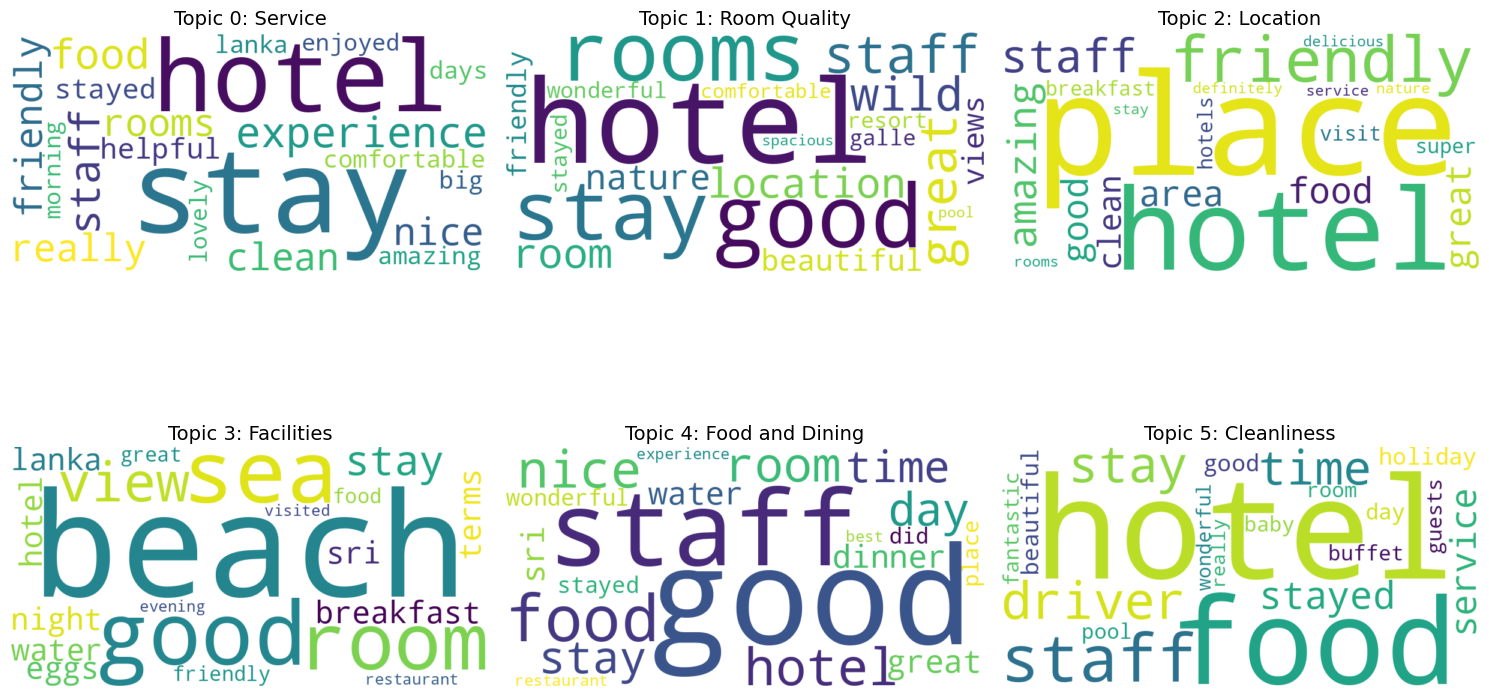

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate and display word clouds for each topic
def plot_wordclouds_with_names(model, feature_names, unique_topic_names, n_top_words=20):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, topic in enumerate(model.components_):
        # Extract top words and their frequencies
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Display the word cloud
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        # Add topic name to the title
        axes[idx].set_title(f"Topic {idx}: {unique_topic_names[idx]}", fontsize=14)
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
plot_wordclouds_with_names(lda_model, vectorizer.get_feature_names_out(), unique_topic_names)



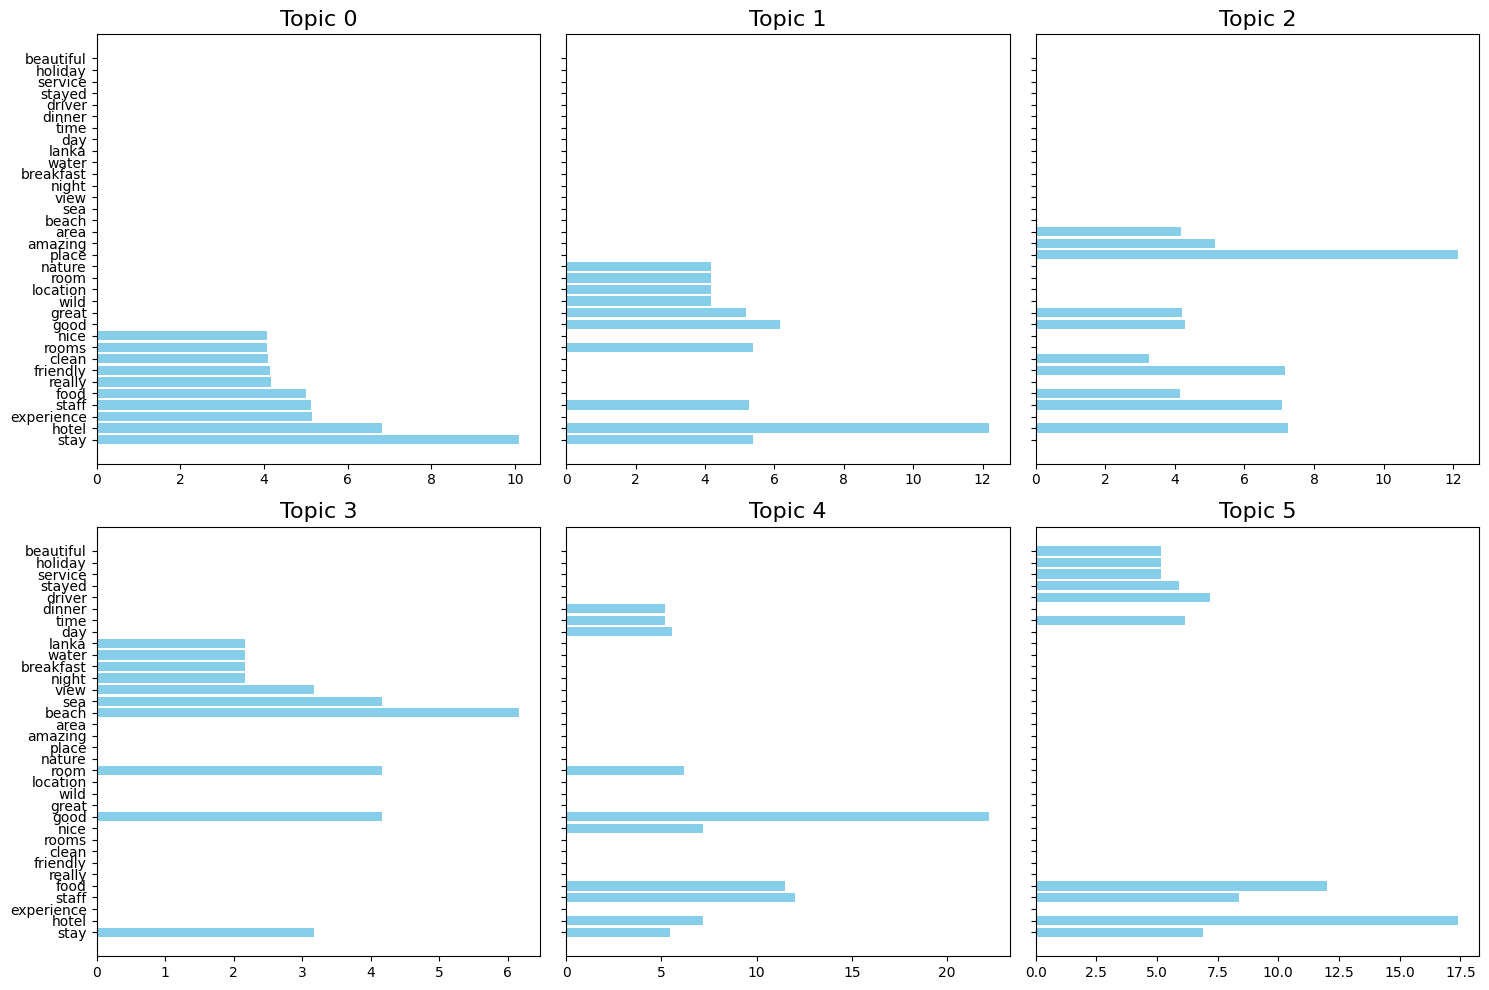

In [17]:
def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    axes = axes.flatten()

    for idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        scores = topic[top_words_idx]

        axes[idx].barh(top_words, scores, color="skyblue")
        axes[idx].invert_yaxis()
        axes[idx].set_title(f"Topic {idx}", fontsize=16)

    plt.tight_layout()
    plt.show()

# Call the function
plot_top_words(lda_model, vectorizer.get_feature_names_out())


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


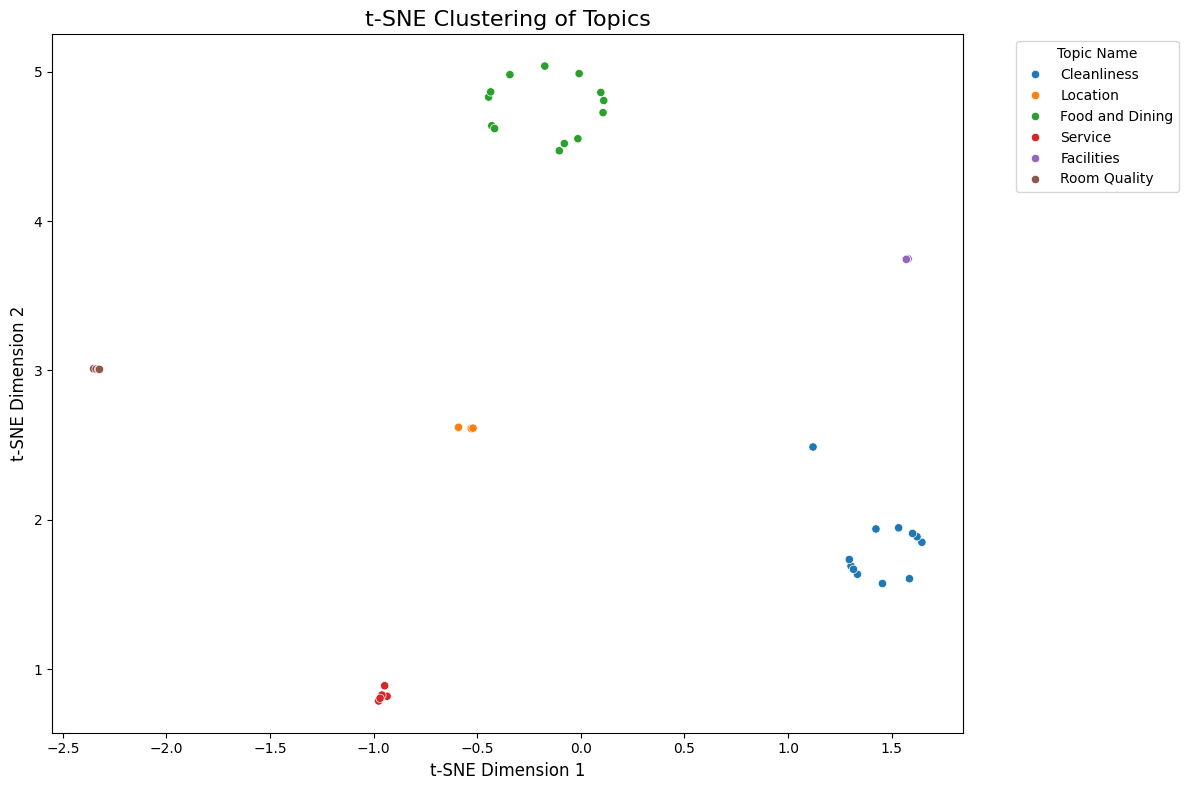

In [18]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce the dimensionality of topic distributions
topic_distributions = lda_model.transform(doc_term_matrix)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
topic_distributions_2d = tsne.fit_transform(topic_distributions)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': topic_distributions_2d[:, 0],
    'y': topic_distributions_2d[:, 1],
    'topic': df['predicted_topic_name']  # Use topic names directly
})

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='topic', palette="tab10", legend="full")
plt.title("t-SNE Clustering of Topics", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(title="Topic Name", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


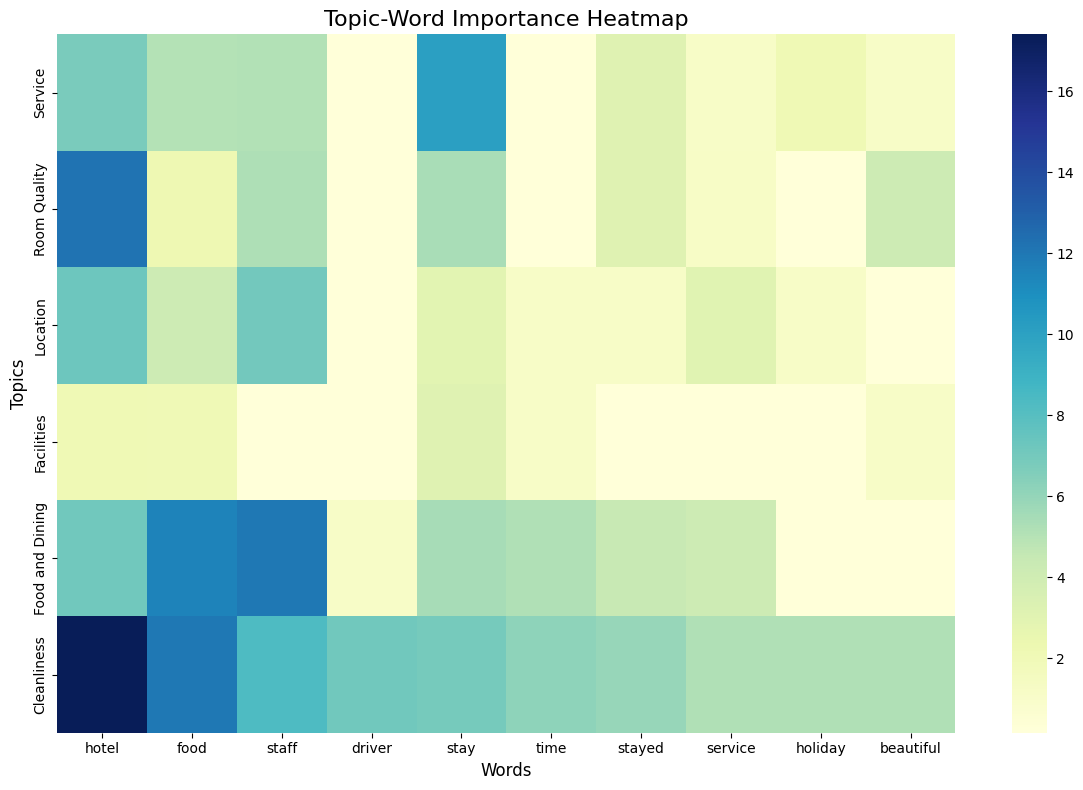

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of top words for each topic
def plot_topic_word_heatmap_with_names(model, feature_names, topic_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)

    # Create heatmap data
    heatmap_data = np.array([
        model.components_[topic_idx, top_word_idx]
        for topic_idx in range(len(model.components_))
        for top_word_idx in top_words_idx
    ]).reshape(len(model.components_), -1)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap="YlGnBu",
        xticklabels=top_words,
        yticklabels=[topic_names.get(i, f"Topic {i}") for i in range(len(topics))],  # Use topic names
        annot=False,
        fmt=".2f"
    )
    plt.title("Topic-Word Importance Heatmap", fontsize=16)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Topics", fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function
plot_topic_word_heatmap_with_names(lda_model, vectorizer.get_feature_names_out(), unique_topic_names)


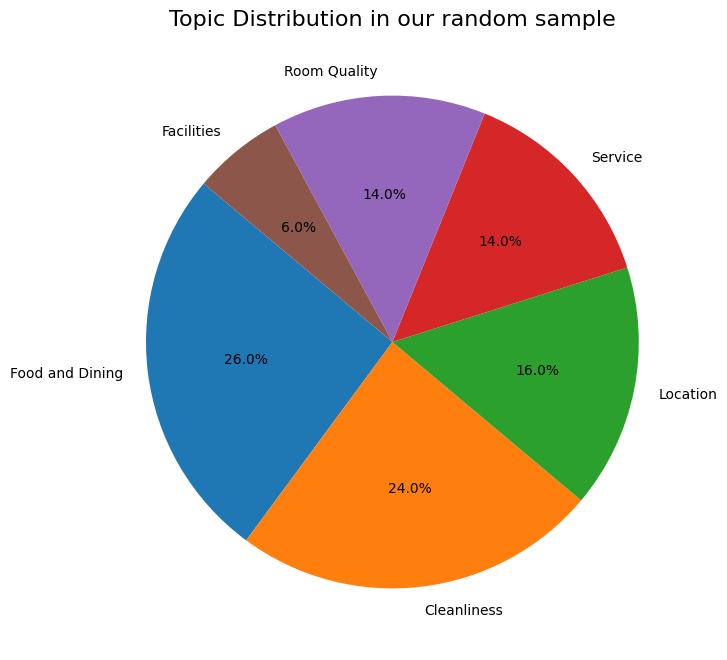

In [20]:
# Calculate the topic distribution
topic_counts = df['predicted_topic'].value_counts(normalize=True)

# Map topic indices to unique topic names
topic_labels = [unique_topic_names.get(i, f"Topic {i}") for i in topic_counts.index]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    topic_counts,
    labels=topic_labels,  # Use topic names
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("tab10")
)
plt.title("Topic Distribution in our random sample", fontsize=16)
plt.show()


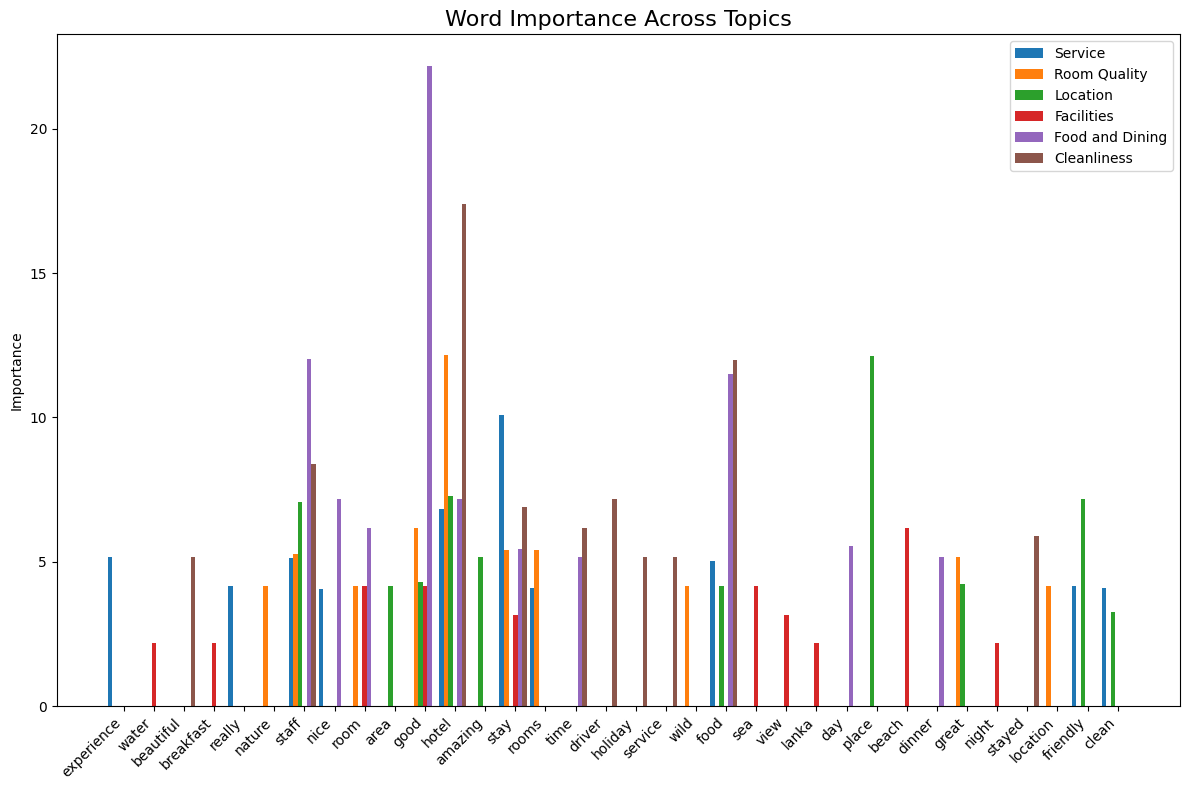

In [21]:
import numpy as np

# Grouped bar chart for word importance
def plot_grouped_barchart(model, feature_names, topic_names, n_top_words=10):
    top_words = []
    word_scores = []

    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words.append([feature_names[i] for i in top_words_idx])
        word_scores.append([topic[i] for i in top_words_idx])

    # Flatten the words and their scores for grouping
    words = list(set([word for sublist in top_words for word in sublist]))
    scores = np.zeros((len(words), len(topic_names)))

    for topic_idx, topic_words in enumerate(top_words):
        for i, word in enumerate(topic_words):
            word_idx = words.index(word)
            scores[word_idx, topic_idx] = word_scores[topic_idx][i]

    # Create grouped bar chart
    x = np.arange(len(words))
    width = 0.15

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, topic_name in enumerate(topic_names):
        ax.bar(x + i * width, scores[:, i], width, label=topic_name)

    ax.set_title("Word Importance Across Topics", fontsize=16)
    ax.set_xticks(x + width * len(topic_names) / 2)
    ax.set_xticklabels(words, rotation=45, ha="right")
    ax.set_ylabel("Importance")
    ax.legend(loc="best", fontsize=10)
    plt.tight_layout()
    plt.show()

# Call the function
plot_grouped_barchart(lda_model, vectorizer.get_feature_names_out(), list(unique_topic_names.values()))


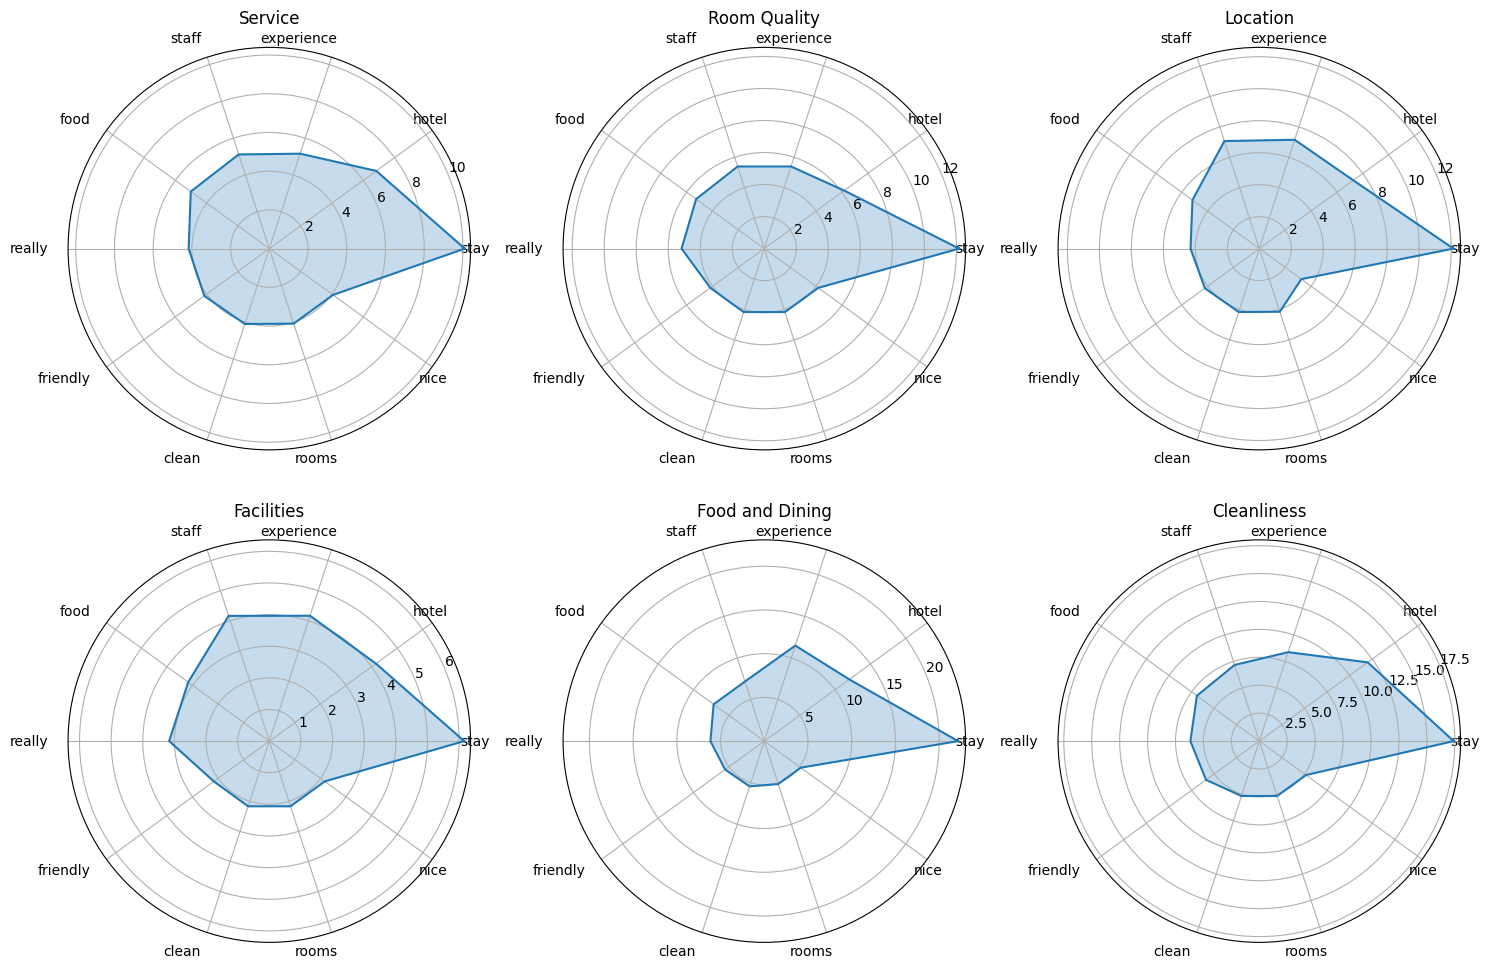

In [22]:
from math import pi

# Radar chart for word importance
def plot_radar_chart(model, feature_names, topic_names, n_top_words=10):
    top_words = []
    word_scores = []

    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words.append([feature_names[i] for i in top_words_idx])
        word_scores.append([topic[i] for i in top_words_idx])

    labels = top_words[0]
    angles = np.linspace(0, 2 * pi, len(labels), endpoint=False).tolist()

    fig, ax = plt.subplots(2, 3, subplot_kw=dict(polar=True), figsize=(15, 10))
    ax = ax.flatten()

    for i, topic_name in enumerate(topic_names):
        scores = word_scores[i] + word_scores[i][:1]  # Circular for radar
        angle_values = angles + angles[:1]
        ax[i].plot(angle_values, scores, label=topic_name)
        ax[i].fill(angle_values, scores, alpha=0.25)
        ax[i].set_title(topic_name, fontsize=12)
        ax[i].set_xticks(angles)
        ax[i].set_xticklabels(labels, fontsize=10, rotation=45, ha="right")
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_radar_chart(lda_model, vectorizer.get_feature_names_out(), list(unique_topic_names.values()))


<ipython-input-23-8eca3f2b63d2>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_accuracy = df.groupby('length_category')['correct_prediction'].mean()
<ipython-input-23-8eca3f2b63d2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=length_accuracy.index, y=length_accuracy.values, palette='viridis')


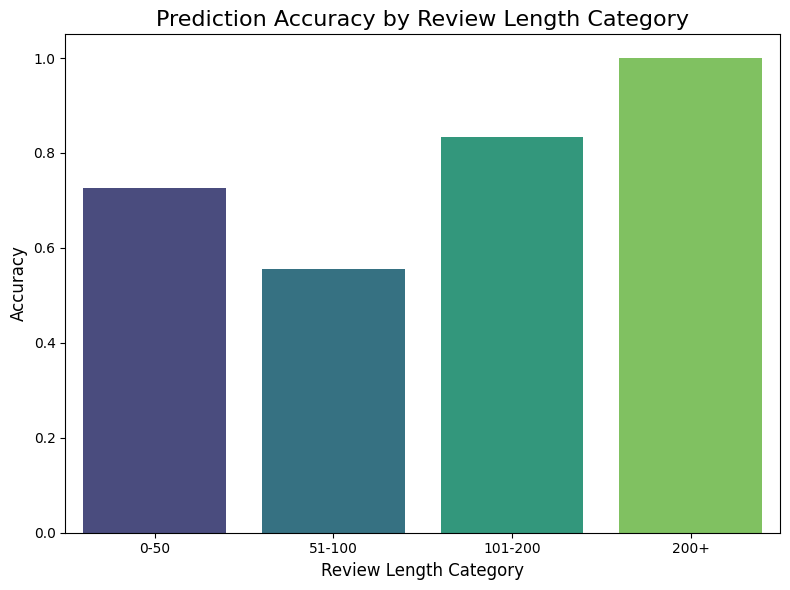

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorize reviews by length
df['length_category'] = pd.cut(df['review_length'], bins=[0, 50, 100, 200, 500], labels=['0-50', '51-100', '101-200', '200+'])

# Calculate accuracy by review length category
length_accuracy = df.groupby('length_category')['correct_prediction'].mean()

# Plot accuracy by review length
plt.figure(figsize=(8, 6))
sns.barplot(x=length_accuracy.index, y=length_accuracy.values, palette='viridis')
plt.title('Prediction Accuracy by Review Length Category', fontsize=16)
plt.xlabel('Review Length Category', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-24-fd9693090da7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_topic.index, y=accuracy_by_topic.values, palette='viridis')


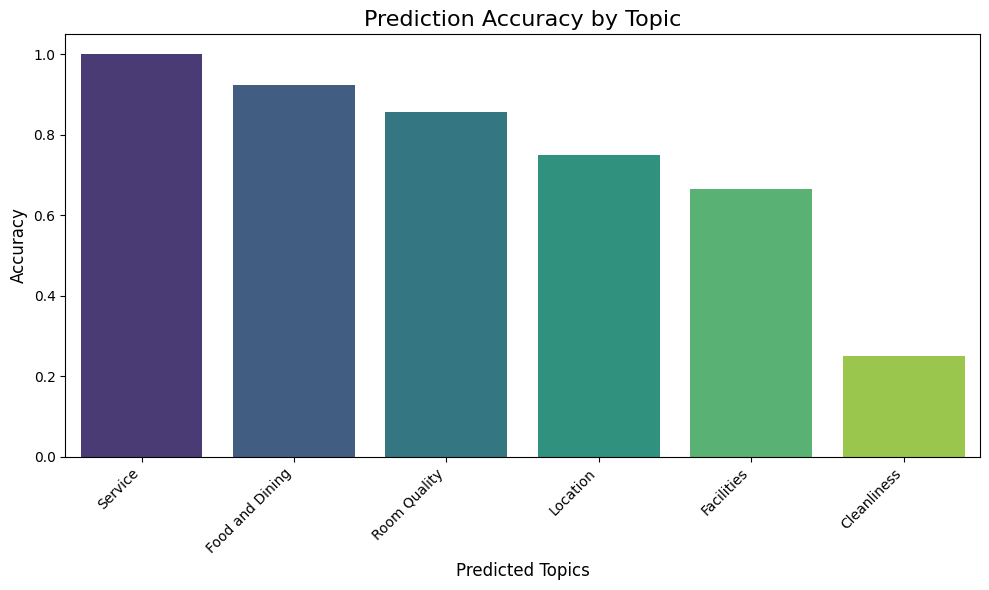

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy by predicted topic
accuracy_by_topic = df.groupby('predicted_topic_name')['correct_prediction'].mean().sort_values(ascending=False)

# Plot the accuracy by topic
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_by_topic.index, y=accuracy_by_topic.values, palette='viridis')
plt.title('Prediction Accuracy by Topic', fontsize=16)
plt.xlabel('Predicted Topics', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
